# _PyChOpMarg_ for IEEE 802.3dj

Original author: David Banas <capn.freako@gmail.com>  
Original date:   August 17, 2024

Copyright &copy; 2024 David Banas; all rights reserved World wide.

## Introduction

This [Jupyter](https://jupyter.org) notebook is intended to help debug recent additions made to the [_PyChOpMarg_](https://pychopmarg.readthedocs.io/en/latest/index.html) Python package in support of the coming IEEE 802.3dj Ethernet standard for 100 GBaud. signalling (200 Gbps using PAM-4).  
I run it from my `pychopmarg` Python virtual environment, into which I've installed:

- `jupyter`
- `PyChOpMarg`
- `matplotlib`
- `xlrd`

This new addition to the 802.3 standard introduces some significant changes to the way equalization optimization is performed for COM analysis.
And I am trying to bring the _PyChOpMarg_ package up-to-date with those changes.
I look at the results of applying COM to certain example channels pertinent to the work of the IEEE 802.3dj task force.

## Imports & Utilities

Here, we import everything we need and define some useful utilities.


In [1]:
%matplotlib inline
# The following seem to cause flaky behavior of this notebook when they're enabled.
# %load_ext autoreload
# %autoreload 2

import cProfile
import pickle
import re
# import time

import numpy    as np
import skrf     as rf

from enum               import Enum
from matplotlib         import pyplot as plt
from matplotlib.axes    import Axes
from matplotlib.ticker  import MultipleLocator
from numpy.fft          import fftshift, irfft, rfft
from pathlib            import Path
from random             import choice, sample
from time               import time
from typing             import Any, Callable, Dict, Optional, TypeAlias

from pychopmarg.com         import COM, OptMode
from pychopmarg.common      import *
from pychopmarg.config.ieee_8023dj import IEEE_8023dj
from pychopmarg.config.template import COMParams
from pychopmarg.optimize    import NormMode
from pychopmarg.utility     import calc_Hffe, from_irfft

ChnlGrpName: TypeAlias = str  # channel group name
ChnlSetName: TypeAlias = str  # channel set name (the stem of the thru channel s4p file name)
ChnlTypName: TypeAlias = str  # channel type name ("thru", "next", or "fext")
ChnlSetComp: TypeAlias = rf.Network | list[rf.Network]   # i.e. - a thru channel, or a list of NEXT/FEXT channels
ChnlSet:     TypeAlias = dict[ChnlTypName, ChnlSetComp]


def fwhm(pr: Rvec) -> float:
    """
    Measure the full width at half maximum of the given pulse response.
    
    Args:
        pr: Pulse response to measure.
        
    Returns:
        fwhm: Full width at half max of largest peak in given signal.

    Notes:
        1. Used to characterize the _bandwidth_ of a given channel.
    """
    pk_loc = np.where(pr == max(pr))[0][0]
    half_max = 0.5 * pr[pk_loc]
    left_hm = pk_loc
    while left_hm > 0 and pr[left_hm] > half_max:
        left_hm -= 1
    right_hm = pk_loc
    while right_hm < (len(pr) - 1) and pr[right_hm] > half_max:
        right_hm += 1
    return right_hm - left_hm


def reflectivity(pr: Rvec) -> float:
    """
    Measure the _reflectivity_ of a channel with the given pulse response.
    
    Args:
        pr: Pulse response of channel.
        
    Returns:
        ref: Reflectivity of channel.

    Notes:
        1. Use sum of: delta-x weighted by power at delta-x.
    """
    pk_loc = np.where(pr == max(pr))[0][0]
    return sum([dn * y**2 for dn, y in enumerate(pr[pk_loc:])])
    

def get_channel_sets(path: Path) -> dict[ChnlGrpName, list[ChnlSet]]:
    """
    Return all available groups of channel sets in the given path.

    Args:
        path: The folder in which to begin searching.
            (Assumed to contain some number of sub-directories,
            in which the actual channel sets are contained.)

    Returns:
        Dictionary of channel groups, each containing a list of channel sets.

    Notes:
        1. A "channel set" is a dictionary containing a thru channel and some number
            of NEXT and FEXT aggressors.
    """
    
    chnl_groups = list(filter(lambda p: p.is_dir(), path.iterdir()))
    chnl_groups.sort()
    channels = {}
    for chnl_grp in chnl_groups:
        channels[chnl_grp.name] = []
        thru_chnls = list(chnl_grp.glob("*[tT][hH][rR][uU]*.[sS]4[pP]"))  # No global option for case insensitive glob().
        thru_chnls.sort()
        for thru_chnl in thru_chnls:
            nexts = list(chnl_grp.glob(re.sub("thru", "[nN][eE][xX][tT][0-9]", thru_chnl.name, flags=re.IGNORECASE)))
            nexts.sort()
            fexts = list(chnl_grp.glob(re.sub("thru", "[fF][eE][xX][tT][0-9]", thru_chnl.name, flags=re.IGNORECASE)))
            fexts.sort()
            channels[chnl_grp.name].append({  # Here we're constructing a "channel set" dictionary.
                "THRU": [thru_chnl],
                "NEXT": nexts,
                "FEXT": fexts
            })
    return channels


def run_com(
    chnl_sets: list[tuple[ChnlGrpName, list[ChnlSet]]],
    com_params: COMParams,
    opt_mode: OptMode = OptMode.MMSE,
    norm_mode: NormMode = NormMode.P8023dj,
    unit_amp: bool = True,
    dbg_dict: Optional[Dict[str, Any]] = None
) -> dict[ChnlGrpName, dict[ChnlSetName, COM]]:
    """
    Run COM on a list of grouped channel sets.

    Args:
        chnl_sets: List of pairs, each consisting of:
            - ch_grp_name: The group name for this list of channel sets.
            - ch_sets: List of channel sets to run.
        params: The COM configuration parameters to use.

    Keyword Args:
        opt_mode: The optimization mode desired.
            Default: OptMode.MMSE
        norm_mode: The normalization mode desired for Rx FFE tap weights.
            Default: NormMode.P8023dj
        dbg_dict: Optional dictionary into which debugging values may be stashed,
            for later analysis.
            Default: None
    
    Returns:
        2D dictionary indexed by channel group name, then by channel set name, containing the completed COM objects.
    """

    theCOMs = {}
    for grp, ch_set in chnl_sets:
        lbl = ch_set['THRU'][0].stem
        print(f"{grp} : {lbl}")
        theCOM = COM(com_params, ch_set)
        
        # Calling the object calculates the COM value, as well as many other intermediate results.
        com = theCOM(opt_mode=opt_mode, norm_mode=norm_mode, unit_amp=unit_amp, dbg_dict=dbg_dict)
    
        if grp in theCOMs:
            theCOMs[grp].update({ch_set['THRU'][0].stem: theCOM})
        else:
            theCOMs.update({grp: {ch_set['THRU'][0].stem: theCOM}})

    return theCOMs


def dBm_Hz(x: Rvec) -> Rvec:
    "Convert (V^2/Hz) to (dBm/Hz), assuming 100 Ohm system impedance."
    return 10 * np.log10(1e3 * x / 100)


def mag_dB(x: Cvec) -> Rvec:
    "Return the magnitude in dB of a complex amplitude vector."
    return 20 * np.log10(np.abs(x))


def plot_group_samps(
    plot_func: Callable[[COM, str, str, str, dict[str, str], Any, Any], None],
    x_lbl: str, y_lbls: tuple[str, str],
    coms: list[tuple[str, dict[str, str], dict[str, dict[str, COM]]]],
    maxRows: int = 3,
    dx=4, dy=3
) -> None:
    """
    Call the given plotting function for several randomly chosen channel sets from each available group.

    Args:
        plot_func: The plotting function to use. Should take the following arguments:
            com: The COM object to use for plotting.
            grp: Channel set group name
            lbl: Channel set name
            name: COM set name
            opts: Plotting options to use
            ax1: First y-axis
            ax2: Second y-axis
        x_lbl: Label for x-axis
        y_lbls: Pair of labels, one for each y-axis
        coms: List of tuples, each containing:
            - name: Identifying name,
            - opts: Plotting options to use,
            - coms: dictionary of COM objects to select from.
                Should be indexed first by group name then by channel set name.

    Keyword Args:
        maxRows: Maximum number of rows desired in resultant plot matrix.
            (Number of columns is equal to number of groups.)
            Default: 3
        dx: Width of individual plots (in.)
            Default: 3
        dy: Height of individual plots (in.)
            Default: 2

    Returns:
        Nothing
    """
    group_names = list(coms[0][2].keys())
    nCols = len(group_names)
    nRows = min(maxRows, min(list(map(lambda grp: len(list(coms[0][2][grp].keys())),
                                      group_names))))
    fig, axs = plt.subplots(nRows, nCols, figsize=(dx * nCols, dy * nRows))
    try:
        assert isinstance(axs[0][0], Axes)
    except:
        axs = [axs,]
    n = 0
    print("     ", end="")
    for grp in group_names:
        print(f"{grp : ^45s}", end="")
        for lbl in sample(sorted(coms[0][2][grp].keys()), nRows):
            col, row = divmod(n, nRows)
            try:
                ax1 = axs[row][col]
            except:
                print(f"axs: {axs}, row: {row}, col: {col}, nRows: {nRows}, nCols: {nCols}")
                raise
            ax2 = ax1.twinx()
            plt.tight_layout()
            for nm, opts, d in coms:
                com  = d[grp][lbl]
                plot_func(com, grp, lbl, nm, opts, ax1, ax2)
            if row == nRows - 1:
                ax1.set_xlabel(x_lbl)
            if col == 0:
                ax1.set_ylabel(y_lbls[0])
            if col == nCols - 1:
                ax2.set_ylabel(y_lbls[1])
            n += 1
    plt.show()


# Global initialization
np.set_printoptions(precision=2, linewidth=200)


### Excel Configuration File Reader

The MATLAB COM code is driven from a MS Excel spreadsheet containing certain recognized parameter names.
So, if we want to run "apples-to-apples" comparisons then we'll need to write a reader that can convert an Excel configuration file into an instance of our own ``COMParams`` data type.

In [2]:
from dataclasses import make_dataclass
from functools import reduce
from itertools import repeat
from pathlib import Path
import re
from typing import Any, Callable, TypeVar
from numpy import arange, array, concatenate, ones
from numpy.typing import NDArray
import pandas as pd
from pychopmarg.config.ieee_8023by import IEEE_8023by
from pychopmarg.config.template import COMParams

T1 = TypeVar("T1")
T2 = TypeVar("T2")
T3 = TypeVar("T3")
T4 = TypeVar("T4")

# Field name translation table (XLS => ``COMParams``)
com_fields: dict[str, str] = {
    "z_p select": "zp_sel",
    "z_p (TX)": "zp_tx",
    "z_p (NEXT)": "zp_next",
    "z_p (FEXT)": "zp_fext",
    "z_p (RX)": "zp_rx",
    "z_bp (TX)": "zbp_tx",
    "z_bp (NEXT)": "zbp_next",
    "z_bp (FEXT)": "zbp_fext",
    "z_bp (RX)": "zbp_rx",
    "c(0)": "c0_min",
    "b_max(1)": "b_max1",
    "b_max(2..N_b)": "b_maxN",
    "ffe_pre_tap_len": "dw",
    "f_b": "fb",
    "Delta_f": "fstep",
    "g_DC_HP": "g_DC2",
    "f_HP_PZ": "f_LF",
}
ignored_fields = [
    "Operational control",
    "COM Pass threshold",
    "Include PCB",
    "Table 92–12 parameters",
    "Parameter",
    "PMD_type",
    "Histogram_Window_Weight",
]

def first(f: Callable[T1, T2]) -> Callable[tuple[T1, T3], tuple[T2, T3]]:
    "Translation of Haskell ``first`` function."
    return lambda pr: (f(pr[0]), pr[1])

def second(f: Callable[T1, T2]) -> Callable[tuple[T3, T1], tuple[T3, T2]]:
    "Translation of Haskell ``second`` function."
    return lambda pr: (pr[0], f(pr[1]))

def compose(*functions):
    "Function composition w/ NO TYPE CHECKING!"
    return reduce(lambda f, g: lambda x: f(g(x)), functions)

def apply2(
    f: Callable[T1, T2],
    g: Callable[T3, T4]
) -> Callable[tuple[T1, T3], tuple[T2, T4]]:
    "Translation of Haskell ``***`` operator."
    return compose(first(f), second(g))

def alternative(
    f: Callable[T1, T2],
    g: Callable[T1, T2],
    x: T1
) -> T2:
    """
    Try ``f`` and if it fails apply ``g``.

    Args:
        f: First function to try.
        g: Second function to try.
        x: Function argument.

    Notes:
        1. It would be preferable to omit ``x`` from the argument list
        and return a function, instead of a value, but we can't do that,
        because Python doesn't allow a try/except block inside a lambda.
    """
    try:
        rslt = f(x)
    except:
        rslt = g(x)
    return rslt

def parse_Mrange(mStr: str) -> NDArray:
    "Parse a string containing an M-code range."
    start, step, stop = list(map(float, mStr.strip("[] ").split(":")))
    if start == stop == 0:
        return array([0.0])
    return arange(start, stop + step / 2, step)

def parse_Mfloat(mStr: str) -> NDArray:
    "Parse a string containing a single M-code number."
    return array([float(mStr)])

def parse_Mfloats(mStr: str) -> NDArray:
    "Parse a string containing a repeated M-code number."
    pattern = r"([-]?[0-9.]+)\*ones\(1,\s*([0-9]+)\)"
    # match = re.search(pattern, mStr, re.DEBUG)  # Leave as example.
    match = re.search(pattern, mStr)
    if match:
        return array([float(match.group(1))] * int(match.group(2)))
    else:
        raise RuntimeError(f"Couldn't parse: '{mStr}'.")

def parse_Mlist(mStr: str) -> NDArray:
    "Parse a string containing an M-code list of numbers."
    tokens = list(map(lambda s: s.strip(","),
                      mStr.strip("[] ").split()))
    try:
        rslt = concatenate(list(map(lambda s: alternative(parse_Mfloat, parse_Mfloats, s),
                                    tokens)))
    except:
        print(f"mStr: {mStr}")
        print(f"tokens: {tokens}")
        # print(f"rslt: {rslt}")
        raise
        
    return rslt
    
def parse_Marray(mStr: str) -> NDArray:
    "Parse a string containing either an M-code range or list of numbers."
    return array(list(filter(lambda x: x is not None,
                             alternative(parse_Mrange, parse_Mlist, mStr))))
    
def parse_Mmatrix(mStr: str) -> NDArray:
    "Parse a string containing an M-code matrix of numbers."
    rslt = array(list(map(parse_Marray, mStr.strip("[]").split(";"))))
    if rslt.shape[0] == 1:
        return rslt.flatten()
    else:
        return rslt

def match_ignored_field_name_prefix(mName: str) -> bool:
    "Match MATLAB field name prefix to any ignored field name."
    for nm in ignored_fields:
        if mName.startswith(nm):
            return True
    return False
    
def cfg_trans(com_cfg: NDArray) -> dict[str, Any]:
    "Translate/filter the names/values of the given 2D NumPy array."
    return dict(map(apply2(lambda s: com_fields[s] if s in com_fields else s,
                           lambda s: parse_Mmatrix(s) if isinstance(s, str) else s),
                    filter(lambda pr: not pd.isna(pr[0]) and not match_ignored_field_name_prefix(pr[0]),
                           com_cfg)))

com_params_dict = {}  # Kept global, so I can inspect it later while debugging.
def get_com_params(cfg_file: Path) -> COMParams:
    "Read a COM configuration XLS file and return an equivalent ``COMParams`` instance."

    global com_params_dict
    
    if cfg_file.suffix == "xlsx":  # You'll need to manually export to `*.xls` from within Excel.
        com_cfg = pd.read_excel(cfg_file, engine_kwargs={"read_only": True})  # Doesn't work, currently.
    else:
        com_cfg = pd.read_excel(cfg_file)

    _com_cfg = com_cfg.to_numpy()
    com_cfg1 = _com_cfg[:, range(0, 2)]
    com_cfg2 = _com_cfg[:, range(9, 11)]

    com_params_dict = vars(IEEE_8023dj).copy()
    com_params_dict.update(cfg_trans(com_cfg1))
    com_params_dict.update(cfg_trans(com_cfg2))

    # Set the Tx tap ranges/steps.
    N_TX_TAPS = 6  # not including the cursor
    N_TX_TAPS_2 = N_TX_TAPS // 2
    tx_taps_min = [0] * N_TX_TAPS
    tx_taps_max = [0] * N_TX_TAPS
    tx_taps_step = [0] * N_TX_TAPS
        
    def set_tap(ix, weights):
        if isinstance(weights, list) or isinstance(weights, np.ndarray):
            tx_taps_min[ix] = min(weights)
            tx_taps_max[ix] = max(weights)
            tx_taps_step[ix] = (tx_taps_max[ix] - tx_taps_min[ix]) / (len(weights) - 1)
        else:  # Assume scalar.
            tx_taps_min[ix] = weights
            tx_taps_max[ix] = weights
            tx_taps_step[ix] = 0
        
    for n in range(N_TX_TAPS_2):
        mKey = f"c(-{n + 1})"
        pKey = f"c({n + 1})"
        if mKey in com_params_dict:
            set_tap(N_TX_TAPS_2 - (n + 1), com_params_dict[mKey])
        if pKey in com_params_dict:
            set_tap(N_TX_TAPS_2 + n, com_params_dict[pKey])

    # Set Rx FFE config.
    if "dw" in com_params_dict:
        assert "ffe_post_tap_len" in com_params_dict, ValueError(
            f"Either both or neither of: 'ffe_pre_tap_len' & 'ffe_post_tap_len' must be given in the configuration spreadsheet!")
        nRxPreTaps = com_params_dict["dw"]
        nRxPostTaps = com_params_dict["ffe_post_tap_len"]
        nRxTaps = nRxPreTaps + 1 + nRxPostTaps  # Includes cursor tap.
        rx_taps_min = array([-0.7] * nRxTaps)
        rx_taps_max = array([0.7] * nRxTaps)
        rx_taps_min[nRxPreTaps] = rx_taps_max[nRxPreTaps] = 1.0  # Set cursor max/min to 1.0 (i.e. - no clipping, because relative).
        if "ffe_pre_tap1_max" in com_params_dict:
            rx_taps_max[nRxPreTaps - 1] = com_params_dict["ffe_pre_tap1_max"]
            rx_taps_min[nRxPreTaps - 1] = -com_params_dict["ffe_pre_tap1_max"]
        if "ffe_post_tap1_max" in com_params_dict:
            rx_taps_max[nRxPreTaps + 1] = com_params_dict["ffe_post_tap1_max"]
            rx_taps_min[nRxPreTaps + 1] = -com_params_dict["ffe_post_tap1_max"]
        if "ffe_tapn_max" in com_params_dict:
            try:
                rx_taps_max[:nRxPreTaps - 1] = com_params_dict["ffe_tapn_max"] * ones(nRxPreTaps - 1)
                rx_taps_max[nRxPreTaps + 2:] = com_params_dict["ffe_tapn_max"] * ones(nRxTaps - nRxPreTaps - 2)
                rx_taps_min[:nRxPreTaps - 1] = -com_params_dict["ffe_tapn_max"] * ones(nRxPreTaps - 1)
                rx_taps_min[nRxPreTaps + 2:] = -com_params_dict["ffe_tapn_max"] * ones(nRxTaps - nRxPreTaps - 2)
            except:
                print(f"nRxPreTaps: {nRxPreTaps}, com_params_dict['ffe_tapn_max']: {com_params_dict['ffe_tapn_max']}")
                raise

    # Make sure CTLE d.c. gains are both lists.
    if not (isinstance(com_params_dict["g_DC"], list) or isinstance(com_params_dict["g_DC"], np.ndarray)):
        com_params_dict["g_DC"] = [com_params_dict["g_DC"]]
    if not (isinstance(com_params_dict["g_DC2"], list) or isinstance(com_params_dict["g_DC2"], np.ndarray)):
        com_params_dict["g_DC2"] = [com_params_dict["g_DC2"]]
        
    rslt = COMParams(
        com_params_dict["fb"],
        com_params_dict["fstep"],
        com_params_dict["fmax"],
        com_params_dict["L"],
        com_params_dict["M"],
        com_params_dict["DER_0"],
        com_params_dict["T_r"],
        com_params_dict["RLM"],
        com_params_dict["A_v"],
        com_params_dict["A_fe"],
        com_params_dict["A_ne"],
        com_params_dict["R_0"],
        com_params_dict["A_DD"],
        com_params_dict["SNR_TX"],
        com_params_dict["eta_0"],
        com_params_dict["sigma_Rj"],
        com_params_dict["f_z"],
        com_params_dict["f_p1"],
        com_params_dict["f_p2"],
        com_params_dict["f_LF"],
        com_params_dict["g_DC"],
        com_params_dict["g_DC2"],
        tx_taps_min,
        tx_taps_max,
        tx_taps_step,
        com_params_dict["c0_min"],
        com_params_dict["f_r"],
        com_params_dict["dfe_min"],
        com_params_dict["dfe_max"],
        rx_taps_min,
        rx_taps_max,
        com_params_dict["dw"],
        com_params_dict["R_d"],
        com_params_dict["C_d"],
        com_params_dict["C_b"],
        com_params_dict["C_p"],
        com_params_dict["L_s"],
        com_params_dict["z_c"],
        com_params_dict["z_p"],
        com_params_dict["gamma0"],
        com_params_dict["a1"],
        com_params_dict["a2"],
        com_params_dict["tau"],
    )
    if "z_pB" in com_params_dict:
        rslt.z_pB = com_params_dict["z_pB"]
    return rslt

## COM Parameter Values

Since I'm trying to compare against the results reported in Adam Healey's January 24, 2024 presentation titled, "Reference receiver framework for 200G/lane electrical interfaces and PHYs", I'm starting with the default configuration for IEEE 802.3dj, but zeroing out the Tx FFE and Rx CTLE, just as Adam does.
I'm also making some other slight changes, according to Adam's list of his configuration values used.

See [Adam's presentation](https://www.ieee802.org/3/dj/public/24_01/healey_3dj_01_2401.pdf), slides 17-18.

(Eventually, should be: IEEE-P802.3dj D1.n, Tables 179-15/16)


In [3]:
# Note: If you want to see the differences between the manual construction (`else` block below) and the configuration spreadsheet then do this:
#
# 1. Run this cell w/ `USE_CFG_SHEET` set to `True`.
# 2. Run this cell w/ `USE_CFG_SHEET` set to `False`.
# 3. Change the type of the next cell from `Raw` to `Code` and run it.

USE_CFG_SHEET = True

if USE_CFG_SHEET:
    COM_CFG_SHEET = 'config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls'
    com_params = get_com_params(Path(COM_CFG_SHEET))
    com_params_xcel = com_params
else:
    com_params = IEEE_8023dj
    com_params.f_z = 1000
    com_params.f_p1 = 1000
    com_params.f_p2 = 1000
    com_params.g_DC = [0]
    com_params.g_DC2 = [-n/2 for n in range(11)]
    com_params.tx_taps_min = [0] * 6
    com_params.tx_taps_max = [0] * 6
    com_params.tx_taps_step = [0] * 6
    com_params.c0_min = 1.0
    com_params.dw = 5
    com_params.SNR_TX = 33.0
    com_params.eta_0 = 6e-9


In [4]:
print(com_params)


COMParams(fb=106.25, fstep=0.01, fmax=40000000000.0, L=4, M=32, DER_0=0.0002, T_r=0.004, RLM=0.95, A_v=0.413, A_fe=0.413, A_ne=0.45, R_0=50, A_DD=0.02, SNR_TX=33, eta_0=6e-09, sigma_Rj=0.01, f_z=1000, f_p1=1000, f_p2=1000, f_LF=1.328125, g_DC=[0], g_DC2=[0], tx_taps_min=[0, 0, 0, 0, 0, 0], tx_taps_max=[0, 0, 0, 0, 0, 0], tx_taps_step=[0, 0, 0, 0, 0, 0], c0_min=1, f_r=0.58, dfe_min=array([0.]), dfe_max=array([0.85]), rx_taps_min=array([-1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]), rx_taps_max=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), dw=5, R_d=array([50., 50.]), C_d=array([[4.0e-05, 9.0e-05, 1.1e-04],
       [4.0e-05, 9.0e-05, 1.1e-04]]), C_b=array([3.e-05, 3.e-05]), C_p=array([4.e-05, 4.e-05]), L_s=array([[0.13, 0.15, 0.14],
       [0.13, 0.15, 0.14]]), z_c=[87.5, 92.5], z_p=[33, 1.8], gamma0=0.0005, a1=0.00089, a2=0.0002, tau=0.006141, z_pB=1.8)


## Identify and Run Channel Sets

Given a top-level directory, assemble the dictionary of groups of "channel sets" available for testing.  
Then, select a subset of these for simulation and run them.

A _group_ of channel sets is created for each subdirectory found.

A _channel set_ consists of:

- a thru channel,
- some number of NEXT aggressors, and
- some number of FEXT aggressors.

NEXT/FEXT aggressors are associated with thru channels, via simple file name pattern matching, substituting "next"/"fext" in for "thru".

**Note:** You can find the channels contributed for work on 802.3dj here:  
[IEEE P802.3dj Tools and Channel Data Area (After 27 Jan 2024)](https://www.ieee802.org/3/dj/public/tools/index.html)

**Note:** Each channel requires a minimum of about 40 seconds of simulation time w/ no Tx FFE or Rx CTLE sweeps defined.
The increment to this runtime per Tx/Rx EQ config. option has not yet been determined.


In [5]:
top_dir = Path("chnl_data/P8023dj/KR")
channel_sets = get_channel_sets(top_dir)
print(f"Channel groups found in '{top_dir}':")
for grp, chnls in channel_sets.items():
    print(f"\t{grp:30s}:\t{len(chnls):4d} channels found.")


Channel groups found in 'chnl_data\P8023dj\KR':
	mellitz_3dj_02_elec_230504    :	  27 channels found.
	mellitz_3dj_03_elec_230504    :	  25 channels found.
	shanbhag_3dj_02_2305          :	   4 channels found.
	weaver_3dj_02_2305            :	  36 channels found.


In [6]:
class ChnlSel(Enum):
    "Test channel selection mode."
    FULL      = 1  # Use all available test channels.
    RANDOM    = 2  # Use `N_RAND` randomly selected channels. (See below.)
    GROUP     = 3  # Use all channels in group: `GRP_NAME`.
    GROUP_SUB = 4  # Use channels: `CHNL_NUMS`, from group: `GRP_NAME`.
    CHANNELS  = 5  # Use channels: `CHNL_NAMES`, from group: `GRP_NAME`.
    RAND_ALL  = 6  # Use `N_RAND` randomly selected channels from each available group.

# Change these, to customize the run of this notebook:
channel_selection_mode = ChnlSel(ChnlSel.RAND_ALL)
N_RAND:     int       = 3                             # Number of channels used in `RANDOM`  and `RAND_ALL` modes.
GRP_NAME:   str       = "weaver_3dj_02_2305"          # Name of group used in `GROUP` and `GROUP_SUB` modes.
CHNL_NUMS:  list[int] = range(1, 3)                   # Channel selection indices used in `GROUP_SUB` mode.
                                                      # Channel names used in `CHANNELS` mode:
CHNL_NAMES: list[str] = ["KR_ch_3in_PCB_NPC_150mm_29AWG_BP_800mm_27AWG_NPC_150mm_29AWG_thru"]  # ,
                         # "KRCA_wXTALK_MX_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm_thru"]

# DON'T CHANGE ANYTHING ELSE BELOW THIS LINE, IN THIS CELL!

# The full set of available test channels:
ch_sets = [(k, chnl_set) for k, v in channel_sets.items()
                         for chnl_set in v]

# The subset of the above that we'll use in this notebook:
match channel_selection_mode:
    case ChnlSel.FULL:
        tested_ch_sets = ch_sets
    case ChnlSel.RANDOM:
        tested_ch_sets = sample(ch_sets, N_RAND)
    case ChnlSel.GROUP:
        tested_ch_sets = [(GRP_NAME, ch_set) for ch_set in channel_sets[GRP_NAME]]
    case ChnlSel.GROUP_SUB:
        tested_ch_sets = [(GRP_NAME, channel_sets[GRP_NAME][n]) for n in CHNL_NUMS]
    case ChnlSel.CHANNELS:
        tested_ch_sets = [(GRP_NAME, cset) for cset in filter(lambda cs: cs['THRU'][0].stem in CHNL_NAMES, channel_sets[GRP_NAME])]
    case ChnlSel.RAND_ALL:
        tested_ch_sets = [(grp, ch_set) for grp in sorted(channel_sets.keys()) for ch_set in sample(channel_sets[grp], N_RAND)]
    case _:
        raise ValueError(f"Unrecognized channel selection mode: {channel_selection_mode}, requested!")

nTests = len(tested_ch_sets)
print(f"{nTests} channel(s) selected for testing. (Approximately {1 * nTests * 40 / 60: .1f} minutes.)") # Assumes we're only running MMSE, below.

12 channel(s) selected for testing. (Approximately  8.0 minutes.)


In [7]:
USE_OLD_DATA  = False   # Set to `False` to re-run the simulation.
# SAVE_NEW_DATA = False  # Set to `True` to save new simulation data for future use.
SAVE_NEW_DATA = channel_selection_mode == ChnlSel.FULL or channel_selection_mode == ChnlSel.RAND_ALL

dbg_dict = {}

if USE_OLD_DATA:
    with open("tested_ch_sets.pickle", "rb") as dump_file:
        tested_ch_sets = pickle.load(dump_file)
    with open("theCOMs_MMSE.pickle", "rb") as dump_file:
        theCOMs = pickle.load(dump_file)
    with open("theCOMs_PRZF.pickle", "rb") as dump_file:
        _theCOMs = pickle.load(dump_file)
else:
    norm_mode = NormMode.P8023dj

    start_time = time()
    # _theCOMs = run_com(tested_ch_sets, com_params, norm_mode=norm_mode, opt_mode=OptMode.PRZF, dbg_dict=dbg_dict)
    # cProfile.run("_theCOMs = run_com(tested_ch_sets, com_params, norm_mode=norm_mode, opt_mode=OptMode.PRZF)", sort="tottime")
    split_time = time()
    theCOMs  = run_com(tested_ch_sets, com_params, norm_mode=norm_mode)
    # cProfile.run("theCOMs  = run_com(tested_ch_sets, com_params, norm_mode=norm_mode)", sort="tottime")
    _theCOMs = theCOMs
    stop_time = time()

    print("Run times:")
    print(f"\tPRZF: {(split_time - start_time) / 60.} minutes")
    print(f"\tMMSE: {(stop_time  - split_time) / 60.} minutes")

if not USE_OLD_DATA and SAVE_NEW_DATA:
    with open("tested_ch_sets.pickle", "wb") as dump_file:
        pickle.dump(tested_ch_sets, dump_file)
    with open("theCOMs_MMSE.pickle", "wb") as dump_file:
        pickle.dump(theCOMs, dump_file)
    with open("theCOMs_PRZF.pickle", "wb") as dump_file:
        pickle.dump(_theCOMs, dump_file)


mellitz_3dj_02_elec_230504 : KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_thru


C:\Users\davibana\.venv\pychopmarg-py313\Lib\site-packages\skrf\network.py:5369: UserWarning: Using a frequency subset:
10000000.0-110000000000.0 Hz, 11000 pts
  return connect(ntwkA, N, ntwkB, 0, num=N)


mellitz_3dj_02_elec_230504 : KRCA_wXTALK_MX_18_PCB-75-75_mm_FO-300-300_mm_CA-500_mm_thru
mellitz_3dj_02_elec_230504 : KRCA_wXTALK_MX_24_PCB-75-75_mm_FO-200-200_mm_CA-1000_mm_thru
mellitz_3dj_03_elec_230504 : C2C_withXtalk_Mezz_2_PCB-60mm_25mm_thru
mellitz_3dj_03_elec_230504 : C2C_withXtalk_Mezz_10_PCB-200mm_60mm_thru
mellitz_3dj_03_elec_230504 : C2C_withXtalk_Mezz_3_PCB-95mm_25mm_thru
shanbhag_3dj_02_2305 : KR_1mCabledBP_TP0TP5_27p4dB_CabledHost_7p85dB_THRU


C:\Users\davibana\.venv\pychopmarg-py313\Lib\site-packages\skrf\network.py:5369: UserWarning: Using a frequency subset:
0.0-80000000000.0 Hz, 8001 pts
  return connect(ntwkA, N, ntwkB, 0, num=N)


shanbhag_3dj_02_2305 : KR_1mCabledBP_TP0TP5_28dB_PCBHost_8dB_THRU
shanbhag_3dj_02_2305 : KR_1mCabledBP_TP0TP5_31p4dB_PCBHost_9p8dB_THRU
weaver_3dj_02_2305 : KR_ch_3in_PCB_NPC_350mm_29AWG_BP_800mm_27AWG_NPC_350mm_29AWG_thru


C:\Users\davibana\.venv\pychopmarg-py313\Lib\site-packages\skrf\network.py:5369: UserWarning: Using a frequency subset:
0.0-100000000000.0 Hz, 1926 pts
  return connect(ntwkA, N, ntwkB, 0, num=N)


weaver_3dj_02_2305 : KR_ch_3in_PCB_NPC_150mm_29AWG_BP_800mm_27AWG_NPC_250mm_29AWG_thru
weaver_3dj_02_2305 : KR_ch_3in_PCB_NPC_300mm_29AWG_BP_800mm_27AWG_NPC_150mm_29AWG_thru
Run times:
	PRZF: 3.973642985026042e-09 minutes
	MMSE: 7.133458058039348 minutes


## MMSE Sanity Checking

Let's plot some things to convince ourselves of the integrity of the MMSE results.


### Equalized Victim Pulse Response

The first thing to check is the fully equalized victim pulse response, since it is the source for so many of the constituents of the COM calculation.  
We'll include the calculated ISI, as a visual indicator of the quality of the Rx FFE tap weight optimization process.  
And we'll repeat the plotting at 3 different zoom scales, to give complete visibillity.

In [36]:
class ZoomMode(Enum):
    "Plot zoom extent."
    FULL  = 1  # Use all available data.
    ISI   = 2  # Show the full ISI sampling used in Rx FFE tap weight optimization.
    PULSE = 3  # Zoom in on the pulse, to inspect its shape in detail.

def plot_pulse_resps_gen(
    zoom: ZoomMode,
    noeq: bool = False
) -> Callable[[], None]:
    """
    Generate a pulse response plotting function for use with ``plot_group_samps()``.

    Args:
        zoom: Zoom mode.

    Keyword Args:
        noeq: Plot unequalized pulse response when ``True``.
            Default: ``False``

    Returns:
        Pulse response plotting function suitable for sending to ``plot_group_samps()``.
    """
    
    def plot_pulse_resps(
        com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any
    ) -> None:
        """
        Plot pulse response.
    
        Args:
            com: The COM instance to use for plotting.
                (Should already have been called, to optimize EQ.)
            grp: The channel group to use for plotting.
                (Should match the name of an immediate subfolder of your top-level channel data folder.)
            lbl: The channel set name within the channel group.
                (Should match the stem of the "<lbl>_{THRU,NEXT,FEXT}.s4p" file names.)
            nm: Extra identification information available to caller
                (e.g. - "MMSE" vs. "PRZF").
            opts: Plotting options.
                (See the ``matplotlib.pyplot`` documentation.)
            ax1: Axis to use for plotting against the left y-axis.
            ax2: Axis to use for plotting against the right y-axis.            
        """
        
        ui = 1 / com.fb
        nspui = com.nspui
        if noeq:
            curs_ix = np.argmax(com.pulse_resps_noeq[0])
        else:
            curs_ix = com.com_rslts["cursor_ix"]
        first_ix = curs_ix - com.nRxPreTaps * nspui
        last_ix = first_ix + com.nRxTaps * nspui
        ix_ffe = range(first_ix, last_ix, nspui)
        clr = opts["color"]
        tISI = com.com_rslts["tISI"]
        # pk_offset = (com.com_rslts["cursor_ix"] - np.argmax(com.pulse_resps_noeq[0])) * com.times[1]
        if noeq:
            ax1.plot(com.times * 1e9, com.pulse_resps_noeq[0] * 1e3,         label=nm, color=clr)
        else:
            ax1.plot(com.times * 1e9, com.com_rslts["pulse_resps"][0] * 1e3, label=nm, color=clr)
        match zoom:
            case ZoomMode.FULL:
                if noeq:
                    pass
                else:
                    ax1.axvline(tISI[0]  * 1e9, color="black")
                    ax1.axvline(tISI[-1] * 1e9, color="black", label="ISIend")
            case ZoomMode.ISI:
                if noeq:
                    # xmin = (tISI[0]  - ui/2 - pk_offset) * 1e9
                    # xmax = (tISI[-1] + ui/2 - pk_offset) * 1e9
                    xmin = (tISI[0]  - ui/2) * 1e9
                    xmax = (tISI[-1] + ui/2) * 1e9
                else:
                    ax1.plot(tISI * 1e9, com.com_rslts["hISI"] * 1e3, "k", label="ISI")
                    xmin = (tISI[0]  - ui/2) * 1e9
                    xmax = (tISI[-1] + ui/2) * 1e9
                ax1.axis(xmin=xmin, xmax=xmax)
            case ZoomMode.PULSE:
                if noeq:
                    # xmin = (com.times[first_ix] - ui/2 - pk_offset) * 1e9
                    # xmax = (com.times[last_ix]  - ui/2 - pk_offset) * 1e9
                    xmin = (com.times[first_ix] - ui/2) * 1e9
                    xmax = (com.times[last_ix]  - ui/2) * 1e9
                else:
                    ax1.plot(tISI * 1e9, com.com_rslts["hISI"] * 1e3, "xk", label="ISI")
                    xmin = (com.times[first_ix] - ui/2) * 1e9
                    xmax = (com.times[last_ix]  - ui/2) * 1e9
                    for _n, _ix in enumerate(ix_ffe):
                        _t = com.times[_ix]
                        if _n == com.nRxPreTaps:  # cursor
                            plt.axvline(_t * 1e9, color=clr, linestyle="-")
                        else:
                            plt.axvline(_t * 1e9, color=clr, linestyle=":")
                ax1.axis(xmin=xmin, xmax=xmax)
            case _:
                raise RuntimeError(
                    f"Unrecognized zoom mode value ({zoom}) received!"
                )
        ax1.legend(loc="upper right")
        ax1.grid()
        plt.title(f"{lbl[-25: -5]}")

    return plot_pulse_resps

              mellitz_3dj_02_elec_230504                   mellitz_3dj_03_elec_230504                      shanbhag_3dj_02_2305                          weaver_3dj_02_2305              

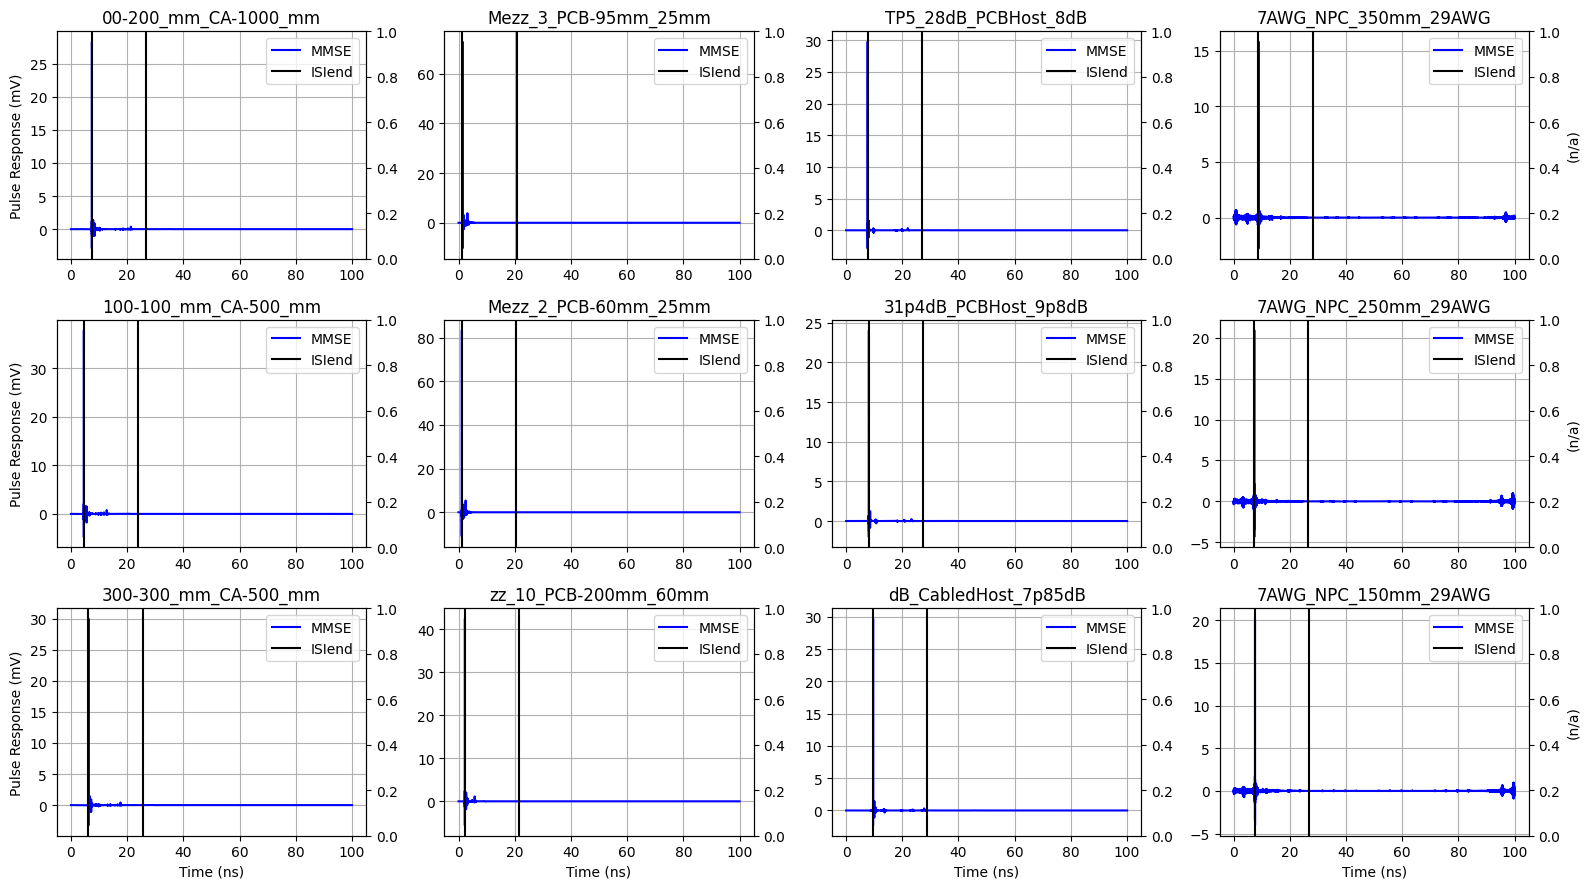

              mellitz_3dj_02_elec_230504                   mellitz_3dj_03_elec_230504                      shanbhag_3dj_02_2305                          weaver_3dj_02_2305              

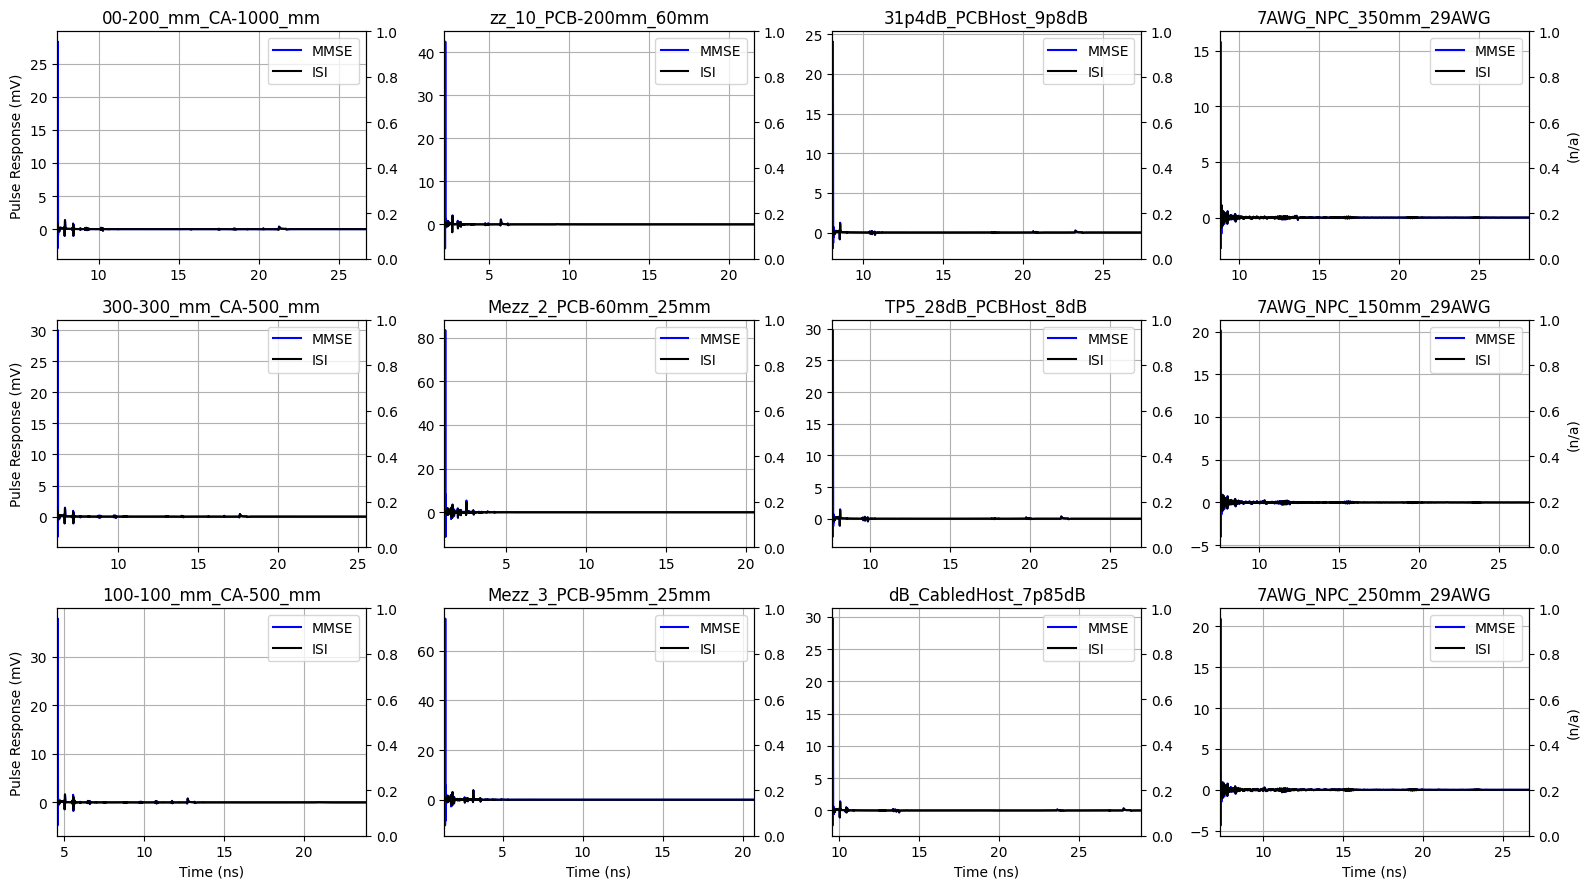

              mellitz_3dj_02_elec_230504                   mellitz_3dj_03_elec_230504                      shanbhag_3dj_02_2305                          weaver_3dj_02_2305              

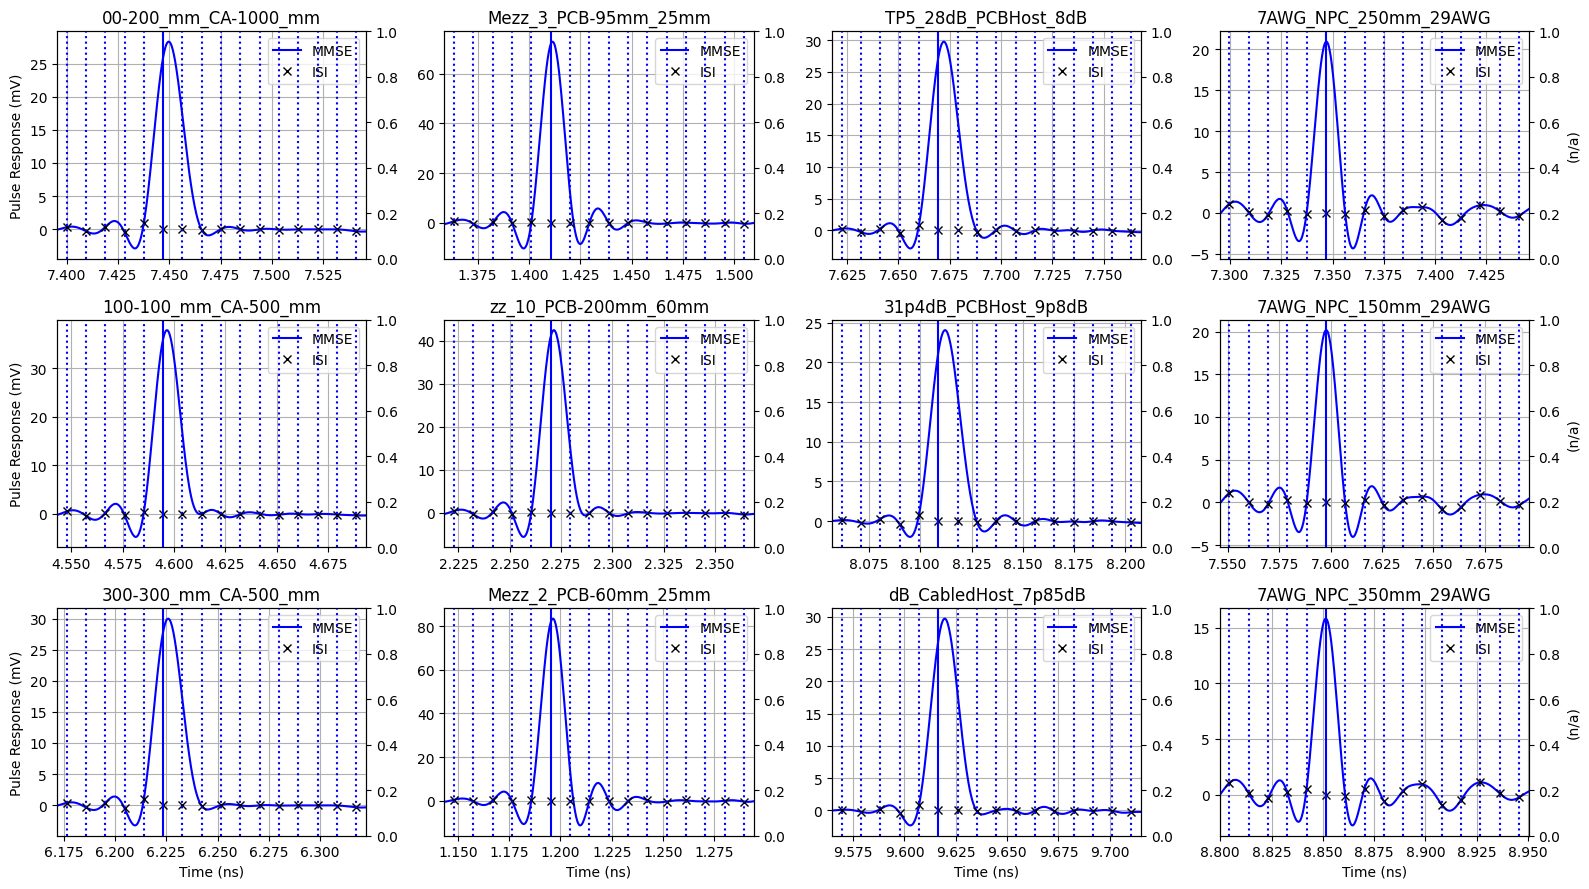

In [ ]:
for zoom in [ZoomMode.FULL, ZoomMode.ISI, ZoomMode.PULSE]:
    plot_group_samps(
        plot_pulse_resps_gen(zoom),
        "Time (ns)",
        ("Pulse Response (mV)", "(n/a)"),
        [("MMSE", {"color": "blue"}, theCOMs),
         # ("PRZF", {"color": "red"}, _theCOMs),
        ],
        dx=4,
        dy=3
    )

**Observations:**

1. In general, there appears to be excessive ringing after the cursor in the PRZF case.
2. The MMSE case seems to consistently yield a smaller _Full Width at Half Maximum_ (FWHM), although the difference is slight.


### Raw Victim Pulse Response

The next thing to check is the raw, unequalized victim pulse response, since I'm seeing some slight amplitude discrepancy in this, wrt/ the MATLAB results.  
(I can't explain this, since it only includes the channel and package models; they should be the same in both tools.)  
We'll repeat the plotting at 3 different zoom scales, just as we did above.

              mellitz_3dj_02_elec_230504                   mellitz_3dj_03_elec_230504                      shanbhag_3dj_02_2305                          weaver_3dj_02_2305              

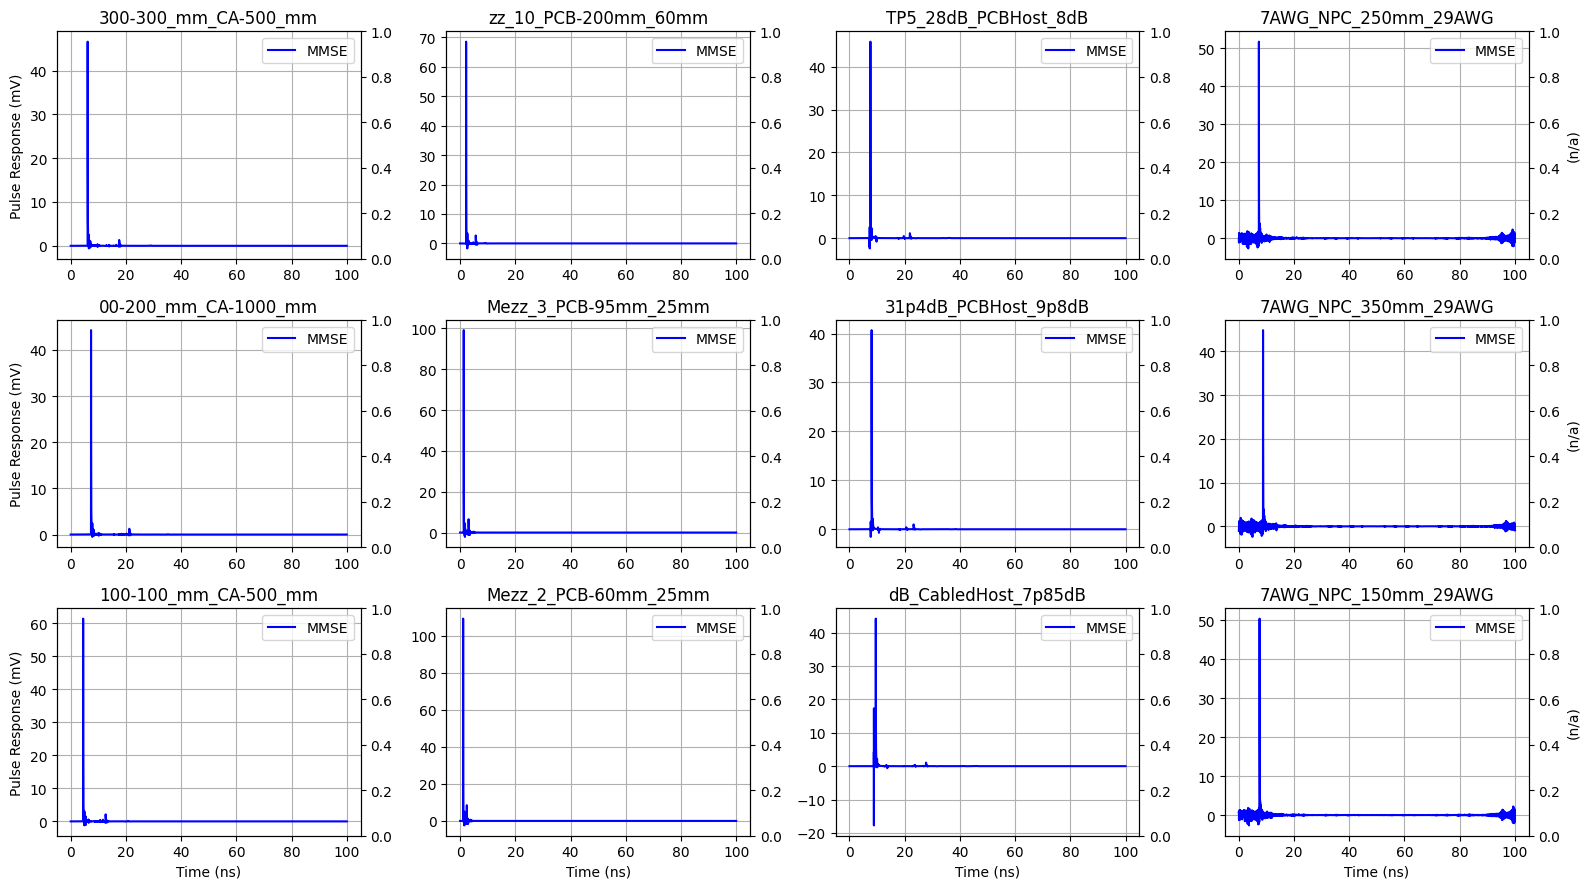

              mellitz_3dj_02_elec_230504                   mellitz_3dj_03_elec_230504                      shanbhag_3dj_02_2305                          weaver_3dj_02_2305              

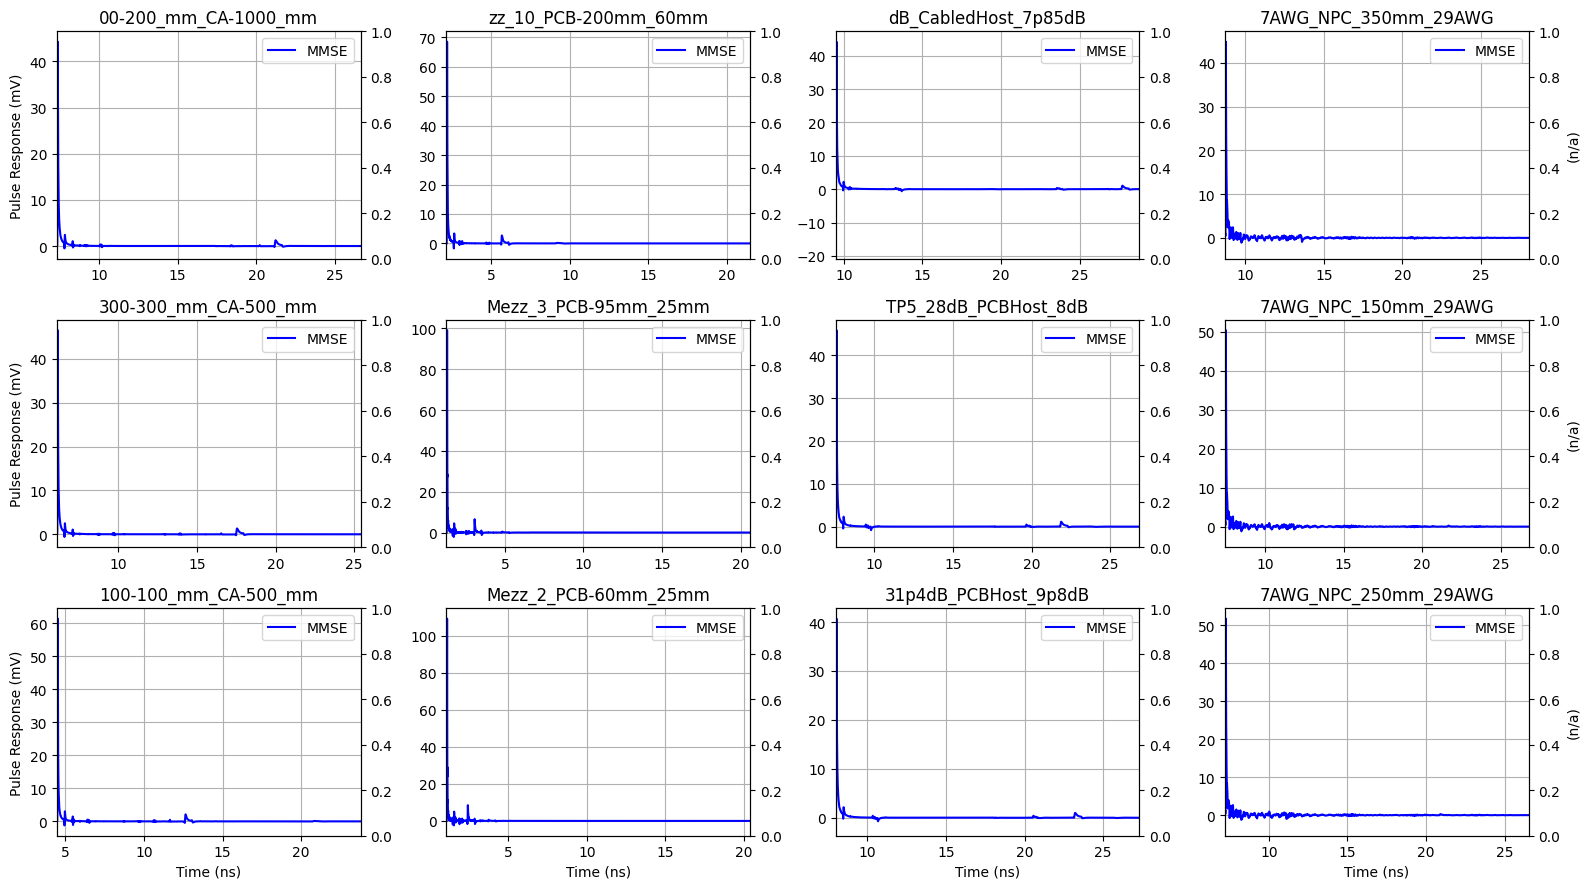

              mellitz_3dj_02_elec_230504                   mellitz_3dj_03_elec_230504                      shanbhag_3dj_02_2305                          weaver_3dj_02_2305              

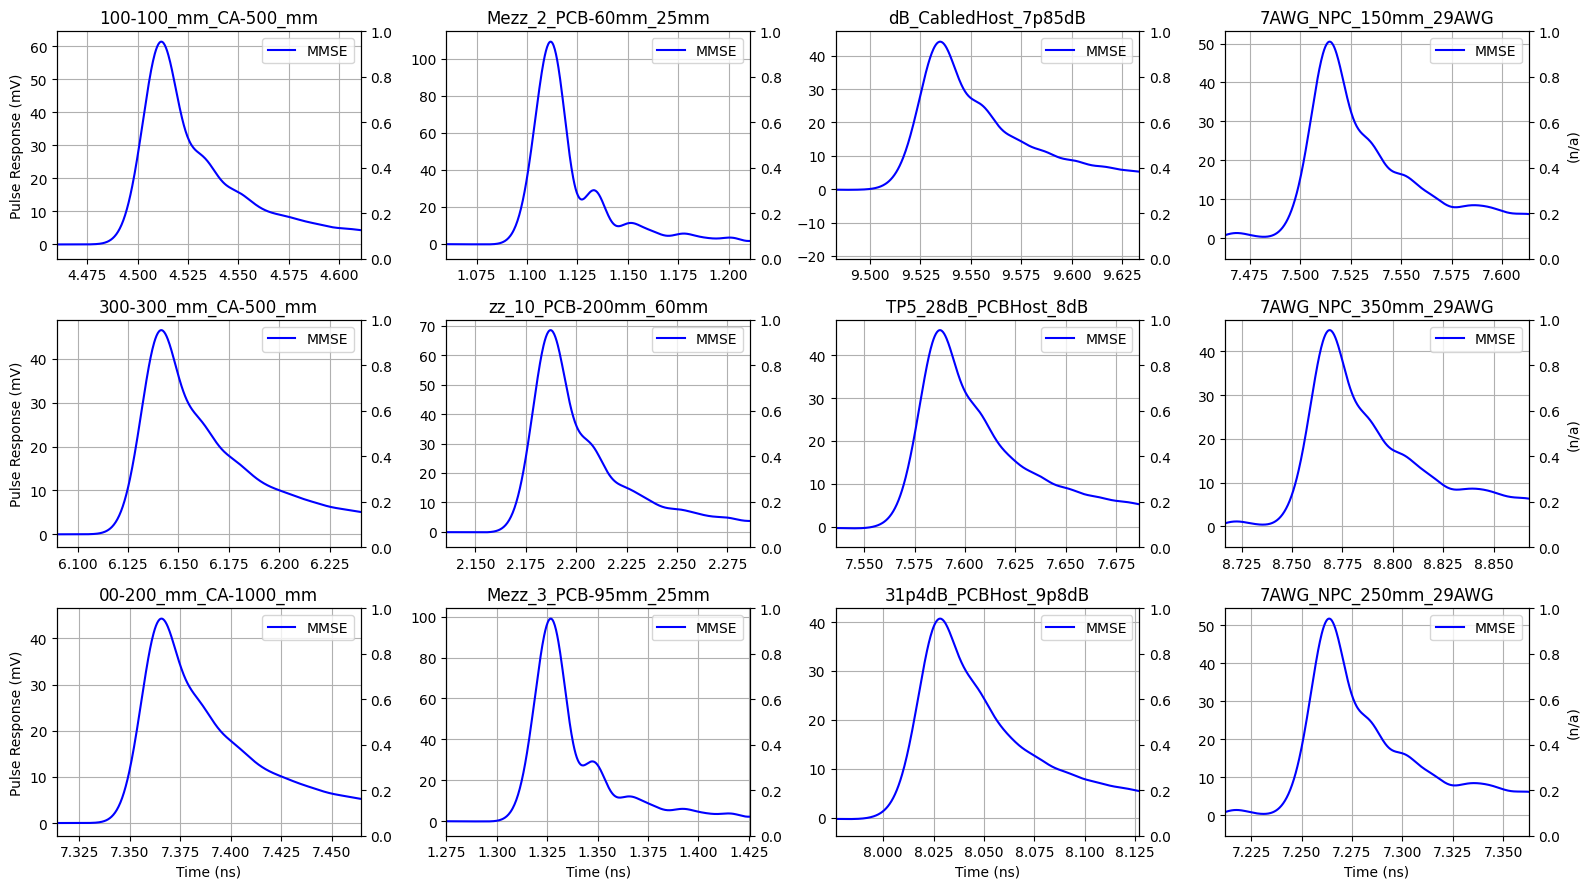

In [9]:
for zoom in [ZoomMode.FULL, ZoomMode.ISI, ZoomMode.PULSE]:
    plot_group_samps(
        plot_pulse_resps_gen(zoom, noeq=True),
        "Time (ns)",
        ("Pulse Response (mV)", "(n/a)"),
        [("MMSE", {"color": "blue"}, theCOMs),
        ],
        dx=4,
        dy=3
    )


**Observations:**

1. In general, there appears to be excessive ringing after the cursor in the PRZF case.
2. The MMSE case seems to consistently yield a smaller _Full Width at Half Maximum_ (FWHM), although the difference is slight.


### Rx FFE Tap Weights

Let's compare the Rx FFE tap weights...

Final Rx FFE Tap Weights (solid) and pre-FFE Pulse Response (dotted):

              mellitz_3dj_02_elec_230504                   mellitz_3dj_03_elec_230504                      shanbhag_3dj_02_2305                          weaver_3dj_02_2305              

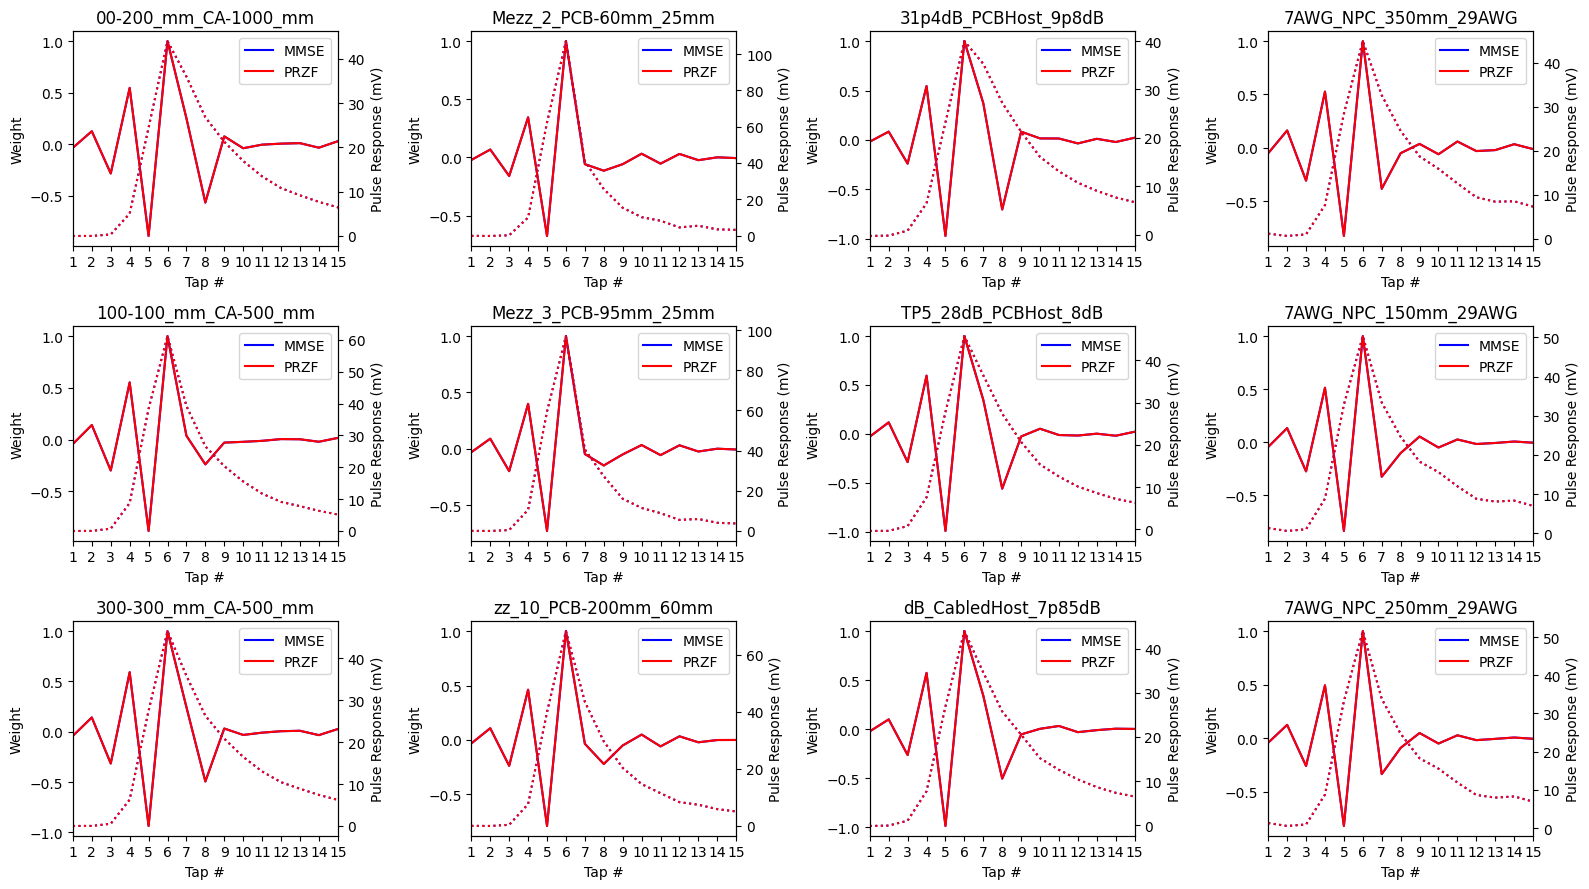

In [10]:
print("Final Rx FFE Tap Weights (solid) and pre-FFE Pulse Response (dotted):\n")

def plot_tap_weights(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot Rx FFE tap weights and pre-FFE pulse response."
    nTaps    = com.nRxTaps
    if not nTaps:
        nTaps = 1
    nPreTaps = com.nRxPreTaps
    tap_ix   = np.arange(nTaps) + 1
    clr = opts["color"]
    ax1.plot(tap_ix, com.rx_taps, label=nm, color=clr)
    pr_samps = com.fom_rslts["pr_samps"]
    curs_loc = np.argmax(pr_samps)
    pr_samps = pr_samps[curs_loc - nPreTaps: curs_loc - nPreTaps + nTaps]
    ax2.plot(tap_ix[:len(pr_samps)], pr_samps * 1e3, ":", color=clr)
    plt.title(f"{lbl[-25:-5]}")
    ax1.set_xlabel("Tap #")
    ax1.set_ylabel("Weight")
    ax2.set_ylabel("Pulse Response (mV)")
    plt.axis(xmin=1, xmax=15)
    ax1.xaxis.set_major_locator(MultipleLocator(1))
    ax1.grid(which='major', axis='x')
    ax2.grid(which='major', axis='y')
    ax1.legend()

plot_group_samps(
    plot_tap_weights,
    "Tap #",
    ("Weight", "Pulse Response (mV)"),
    [("MMSE", {"color": "blue"}, theCOMs),
     ("PRZF", {"color": "red"}, _theCOMs),
    ],
    dx=4,
    dy=3
)


**Observations:**

1. The post-cursor tap weights in the PRZF case appear to be consistently over-aggressive.

    - That seems consistent with the excessive post-cursor ringing in the victim pulse response noticed above.
  
**Questions:**

1. What is the cause of the marked difference in pre-FFE pulse response in some cases above?

    - Is this just the result of slight differences in cursor location selection?


### Rx FFE Frequency Response

Here, we plot the frequency response of the Rx FFE, again comparing the PRZF and MMSE cases.

              mellitz_3dj_02_elec_230504                   mellitz_3dj_03_elec_230504                      shanbhag_3dj_02_2305                          weaver_3dj_02_2305              

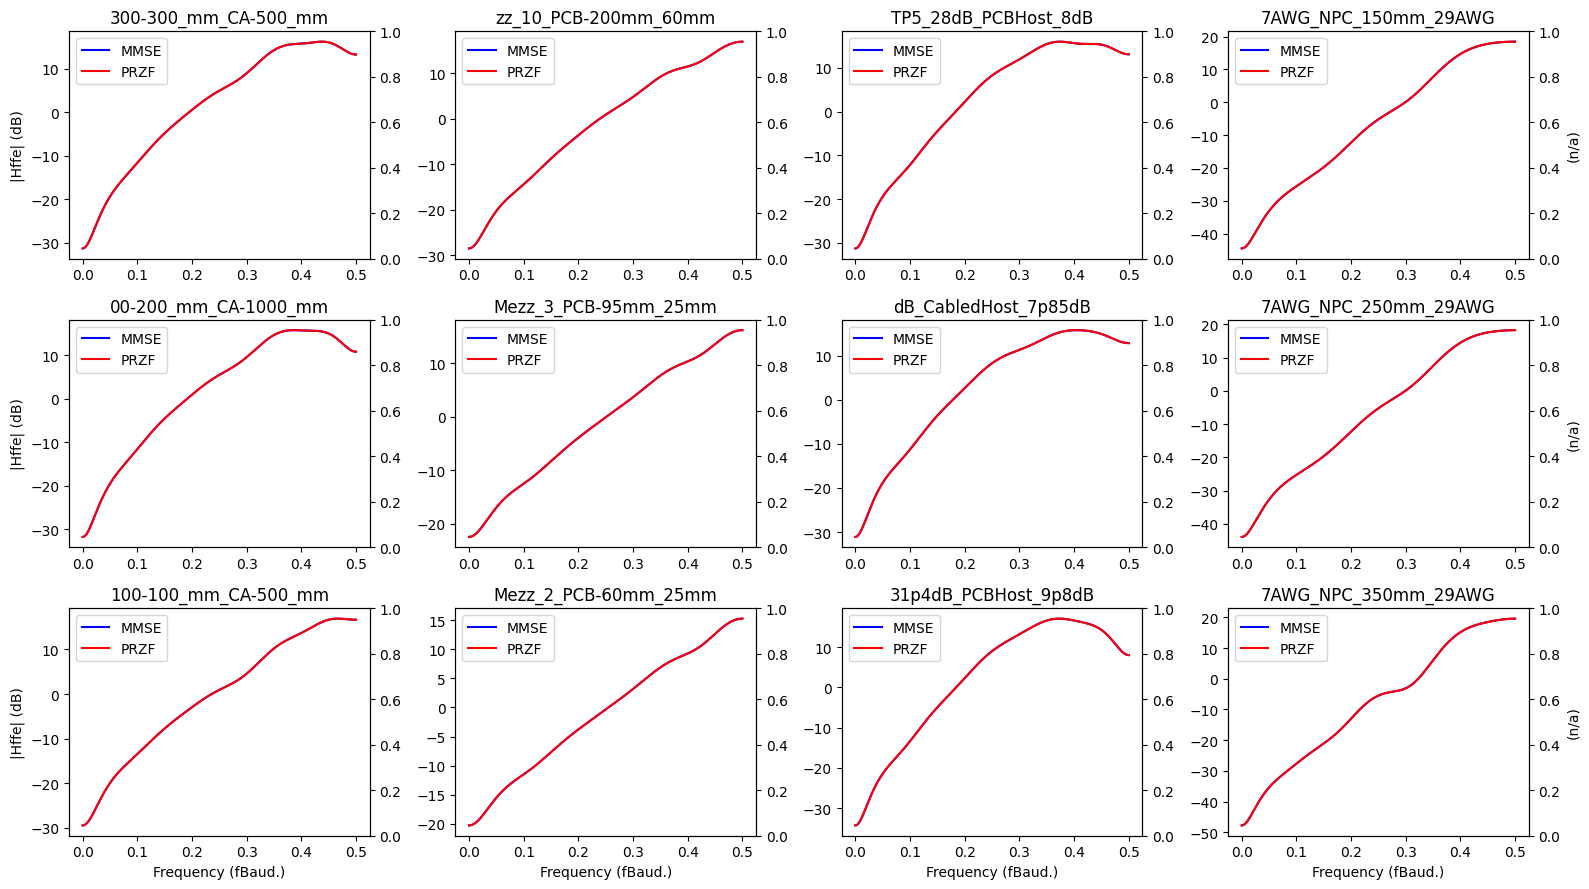

In [11]:
def plot_Hffe(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot the Rx FFE transfer functions."
    Hffe = calc_Hffe(com.freqs, 1/com.fb, np.array(com.rx_taps).flatten(), com.nRxTaps - com.nRxPreTaps - 1, hasCurs=True)
    Hffe_2 = abs(rfft(from_irfft(irfft(np.abs(Hffe) ** 2), com.t_irfft, com.times, com.nspui)))
    clr = opts["color"]
    _f = np.linspace(0, 0.5, len(Hffe_2))
    ax1.plot(_f, 20*np.log10(abs(Hffe_2)), label=nm, color=clr)
    ax1.grid()
    ax1.legend()  # loc="lower left")
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(plot_Hffe, "Frequency (fBaud.)", ("|Hffe| (dB)", "(n/a)"), [("MMSE", {"color": "blue"}, theCOMs),
                                                                             ("PRZF", {"color": "red"},  _theCOMs)])


### Noise & Interference PMFs

Here, we look at the difference in the noise and interference PMFs used to calculate $A_{ni}$.


              mellitz_3dj_02_elec_230504          

C:\Users\davibana\AppData\Local\Temp\ipykernel_24400\2814357779.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.semilogy(y * 1e3, com.com_rslts['pJ'],   label="pJ",   color="blue",   linestyle=opts["linestyle"])


         mellitz_3dj_03_elec_230504                      shanbhag_3dj_02_2305                          weaver_3dj_02_2305              

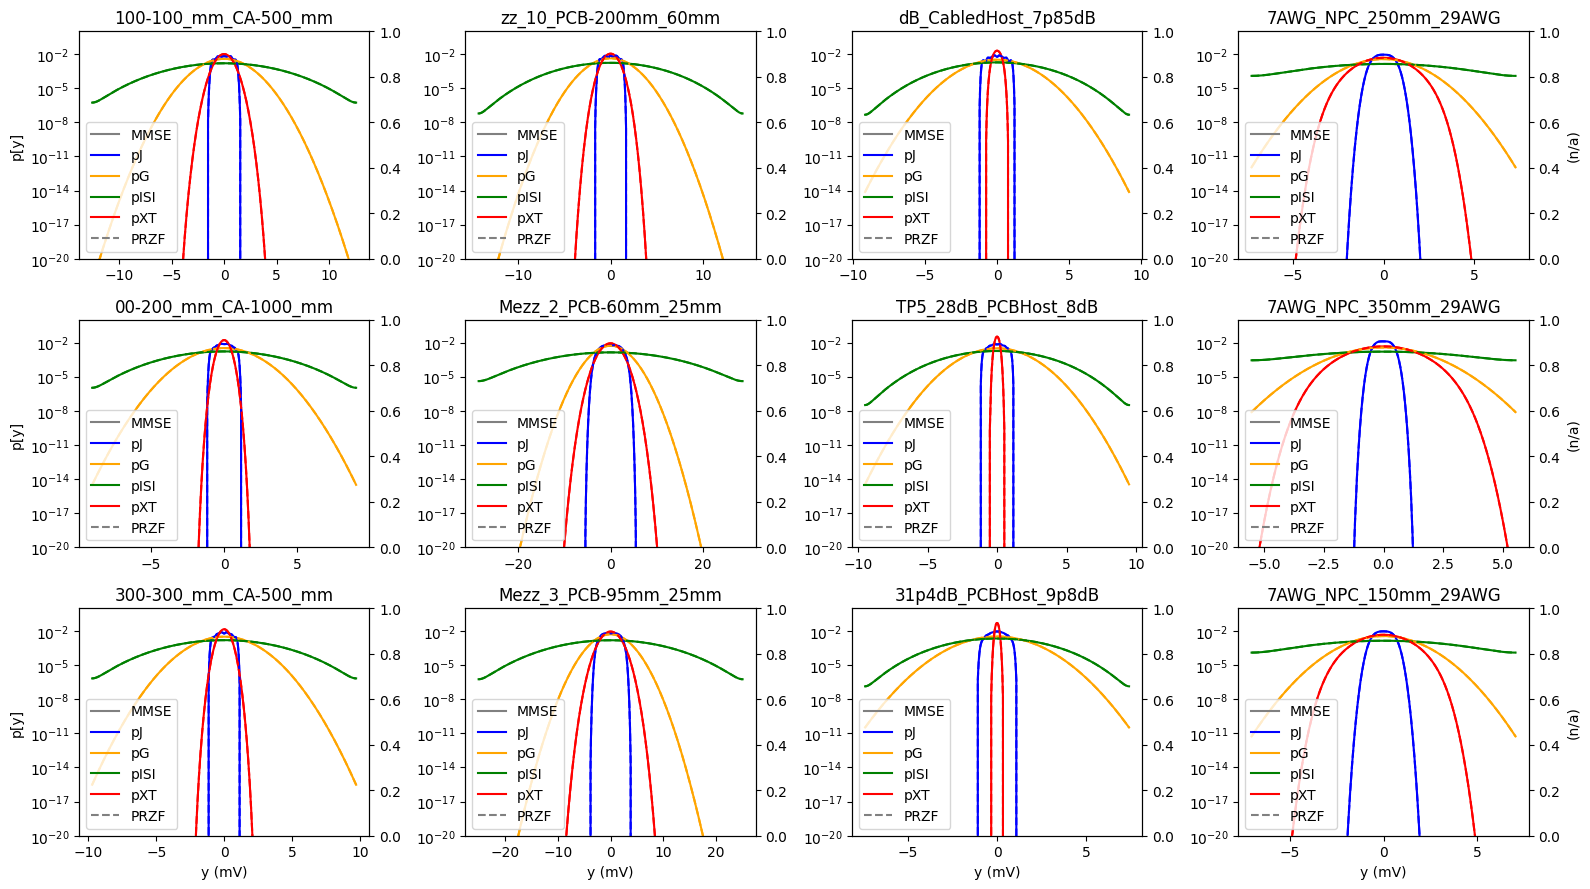

In [12]:
def plot_pmfs(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot various components of the noise & interference PMF."
    ax1.plot([0, 1], [0, 0], label=nm, color="gray", linestyle=opts["linestyle"])  # Just for legend.
    if nm == "PRZF":
        ax1.legend(loc="lower left")
    y = com.com_rslts["y"]
    ax1.semilogy(y * 1e3, com.com_rslts['pJ'],   label="pJ",   color="blue",   linestyle=opts["linestyle"])
    ax1.semilogy(y * 1e3, com.com_rslts['pG'],   label="pG",   color="orange", linestyle=opts["linestyle"])
    ax1.semilogy(y * 1e3, com.com_rslts['pISI'], label="pISI", color="green",  linestyle=opts["linestyle"])
    ax1.semilogy(y * 1e3, com.com_rslts['pXT'],  label="pXT",  color="red",    linestyle=opts["linestyle"])
    ax1.axis(ymin=1e-20, ymax=1)
    ax1.grid()
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(
    plot_pmfs,
    "y (mV)",
    ("p[y]", "(n/a)"),
    [("MMSE", {"linestyle": "solid"},  theCOMs),
     ("PRZF", {"linestyle": "dashed"}, _theCOMs),
    ],
    dx=4,
    dy=3
)


## MATLAB vs. _PyChOpMarg_

Let's compare the MATLAB results to our _PyChOpMarg_ (MMSE) results.  
As per the request made in D1.2, we'll use the new v4.70 version of the M-code.


### MATLAB Code Runner

We need a way to run the MATLAB COM code under Python control.


In [13]:
import subprocess

# MATLAB_EXEC = "/Applications/MATLAB_R2024b.app/bin/matlab"  # Mac
MATLAB_EXEC = "C:/Program Files/MATLAB/R2024b/bin/matlab.exe"  # PC

COM_MATLAB_RESULTS: TypeAlias = dict[str, Any]

def run_com_matlab(
    chnl_sets: list[tuple[ChnlGrpName, list[ChnlSet]]],
    cfg_sheet: Path,
    # opt_mode: OptMode = OptMode.MMSE,
    # norm_mode: NormMode = NormMode.P8023dj,
    # unit_amp: bool = True,
    # dbg_dict: Dict[str, Any] = None
) -> dict[ChnlGrpName, dict[ChnlSetName, COM_MATLAB_RESULTS]]:
    """
    Run COM on a list of grouped channel sets, using the MATLAB code.

    Args:
        chnl_sets: List of pairs, each consisting of:
            - ch_grp_name: The group name for this list of channel sets.
            - ch_sets: List of channel sets to run.
        cfg_sheet: MS Excel configuration spreadsheet for all runs.
    """

    results = {}
    for grp, ch_set in chnl_sets:
        lbl = ch_set['THRU'][0].stem
        n_fexts = len(ch_set["FEXT"])
        cmd_str = ", ".join([
             f"com_ieee8023_93a_470('{cfg_sheet}'",
             f"{len(ch_set['FEXT'])}, {len(ch_set['NEXT'])}, '{ch_set['THRU'][0]}'",
             ", ".join(list(map(lambda ch: f"'{str(ch)}'", ch_set['FEXT'] + ch_set['NEXT'])))]) + ");"
        print(f"\nCommand:\n{cmd_str}")
        result = subprocess.run([MATLAB_EXEC, "-nodisplay", "-batch", cmd_str], capture_output=True, text=True)
        # result = subprocess.run([MATLAB_EXEC, cmd_str], capture_output=True, text=True)
        if grp in results:
            results[grp].update({lbl: {"proc_rslt": result}})
        else:
            results.update({grp: {lbl: {"proc_rslt": result}}})
    return results


### Run Channels in MATLAB

With all the pieces in place, let's run our set of test channels through MATLAB COM analysis.

The actual command strings are dumped, in case we want to run a particular case manually in the MATLAB tool and dig deeper.

In [14]:
# COM_CFG_SHEET = 'config_com_ieee8023_93a=100GBASE-KR4.xls'
COM_CFG_SHEET = 'config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls'
matlab_results = run_com_matlab(tested_ch_sets, COM_CFG_SHEET)


Command:
com_ieee8023_93a_470('config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls', 5, 3, 'chnl_data\P8023dj\KR\mellitz_3dj_02_elec_230504\KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_thru.s4p', 'chnl_data\P8023dj\KR\mellitz_3dj_02_elec_230504\KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_fext1.s4p', 'chnl_data\P8023dj\KR\mellitz_3dj_02_elec_230504\KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_fext2.s4p', 'chnl_data\P8023dj\KR\mellitz_3dj_02_elec_230504\KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_fext3.s4p', 'chnl_data\P8023dj\KR\mellitz_3dj_02_elec_230504\KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_fext4.s4p', 'chnl_data\P8023dj\KR\mellitz_3dj_02_elec_230504\KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_fext5.s4p', 'chnl_data\P8023dj\KR\mellitz_3dj_02_elec_230504\KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_next1.s4p', 'chnl_data\P8023dj\KR\mellitz_3dj_02_elec_230504\KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_m

In [15]:
for grp in matlab_results.keys():
    print(f"{grp}:")
    rslts = matlab_results[grp]
    for chnl in rslts.keys():
        print(f"\t{chnl}: ", end="")
        rslt = rslts[chnl]
        if rslt["proc_rslt"].returncode:
            print(f"ERROR")
        else:
            print(f"SUCCESS")

for grp in matlab_results.keys():
    rslts = matlab_results[grp]
    for chnl in rslts.keys():
        rslt = rslts[chnl]
        if rslt["proc_rslt"].returncode:
            print(f"{grp}/{chnl}: ERROR")            
            print(rslt["proc_rslt"].stderr)

# for grp in matlab_results.keys():
#     rslts = matlab_results[grp]
#     for chnl in rslts.keys():
#         print(f"{grp} => {chnl}:")
#         rslt = rslts[chnl]
#         print(f"STDOUT:\n{rslt.stdout}")
#         print(f"\nSTDERR:\n{rslt.stderr}")

mellitz_3dj_02_elec_230504:
	KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_thru: SUCCESS
	KRCA_wXTALK_MX_18_PCB-75-75_mm_FO-300-300_mm_CA-500_mm_thru: SUCCESS
	KRCA_wXTALK_MX_24_PCB-75-75_mm_FO-200-200_mm_CA-1000_mm_thru: SUCCESS
mellitz_3dj_03_elec_230504:
	C2C_withXtalk_Mezz_2_PCB-60mm_25mm_thru: SUCCESS
	C2C_withXtalk_Mezz_10_PCB-200mm_60mm_thru: SUCCESS
	C2C_withXtalk_Mezz_3_PCB-95mm_25mm_thru: SUCCESS
shanbhag_3dj_02_2305:
	KR_1mCabledBP_TP0TP5_27p4dB_CabledHost_7p85dB_THRU: SUCCESS
	KR_1mCabledBP_TP0TP5_28dB_PCBHost_8dB_THRU: SUCCESS
	KR_1mCabledBP_TP0TP5_31p4dB_PCBHost_9p8dB_THRU: SUCCESS
weaver_3dj_02_2305:
	KR_ch_3in_PCB_NPC_350mm_29AWG_BP_800mm_27AWG_NPC_350mm_29AWG_thru: SUCCESS
	KR_ch_3in_PCB_NPC_150mm_29AWG_BP_800mm_27AWG_NPC_250mm_29AWG_thru: SUCCESS
	KR_ch_3in_PCB_NPC_300mm_29AWG_BP_800mm_27AWG_NPC_150mm_29AWG_thru: SUCCESS


### Parse MATLAB Results

Now, we need to parse the MATLAB COM script results, which are in Human readable text of the form:

```
<strong>--- Testcase <n> results ---</strong>
<key>: <value>
...
```

which lends itself quite naturally to the construction of a Python dictionary.


In [16]:
for grp in matlab_results.keys():
    rslts = matlab_results[grp]
    for chnl in rslts.keys():
        rslt = rslts[chnl]
        ds = []
        d = {}
        for line in rslt["proc_rslt"].stdout.splitlines():
            if "<strong>--- Testcase" in line:
                ds.append(d)
                d = {}
            else:
                toks = line.split(":")
                if len(toks) == 2:
                    d.update({toks[0].strip(): toks[1].strip()})
        ds.append(d)
        rslt.update({"parse_rslts": ds})

### Comparison Results

Now that we've got the MATLAB results parsed, let's see how they compare to those of _PyChOpMarg_.

#### Tabulated Data

First, let's look at some simple tabulated comparison data of certain key results.

In [17]:
print("All 'Sigma_?' values have units of mV.")
print("\nGroup\tChannel\t\t\t\t\t\t  COM (dB)\t  FOM (dB)\t  As (mV)\t  Ani (mV)\t  Sigma_G\t  Sigma_N\t  Sigma_ISI\t  Sigma_XT")
print("\t\t\t\t\t\t\tPyCOM  Mcode\tPyCOM  Mcode\tPyCOM  Mcode\tPyCOM  Mcode\tPyCOM  Mcode\tPyCOM  Mcode\tPyCOM  Mcode\tPyCOM  Mcode")
print("=" * 180)
for grp in theCOMs.keys():
    print(grp)
    for lbl in theCOMs[grp].keys():
        print(f"\t{lbl[-40:]:41s}", end="")
        pcom = theCOMs[grp][lbl].com_rslts
        pfom = theCOMs[grp][lbl].fom_rslts
        mres = matlab_results[grp][lbl]['parse_rslts'][1]
        print(f"\t{pcom['COM']:4.1f}   {float(mres['COM_dB']):4.1f}\t{pfom['FOM']:4.1f}   {float(mres['FOM']):4.1f}\t {pcom['As'] * 1e3:4.1f}   {float(mres['available_signal_after_eq_mV']):4.1f}\t {pcom['Ani'] * 1e3:4.1f}   {float(mres['Peak_ISI_XTK_and_Noise_interference_at_BER_mV']):4.1f}\t{pcom['sigma_G'] * 1e3:4.2f}    {float(mres['sgm_G'])*1e3:4.2f}\t{pcom['sigma_N'] * 1e3:4.2f}    {float(mres['sgm_N'])*1e3:4.2f}\t{pcom['sigma_ISI'] * 1e3:4.2f}    {float(mres['sgm_isi'])*1e3:4.2f}\t{pfom['sigma_XT'] * 1e3:4.2f}    {float(mres['sgm_xt'])*1e3:4.2f}")


All 'Sigma_?' values have units of mV.

Group	Channel						  COM (dB)	  FOM (dB)	  As (mV)	  Ani (mV)	  Sigma_G	  Sigma_N	  Sigma_ISI	  Sigma_XT
							PyCOM  Mcode	PyCOM  Mcode	PyCOM  Mcode	PyCOM  Mcode	PyCOM  Mcode	PyCOM  Mcode	PyCOM  Mcode	PyCOM  Mcode
mellitz_3dj_02_elec_230504
	CB-75-75_mm_FO-100-100_mm_CA-500_mm_thru 	-0.2    3.7	 9.9   14.6	 11.4   12.3	 11.7    8.0	1.32    1.30	0.99    0.95	3.17    1.60	0.27    0.43
	CB-75-75_mm_FO-300-300_mm_CA-500_mm_thru 	-0.4    2.5	 9.5   13.5	  8.8    8.4	  9.2    6.3	1.26    1.20	1.06    1.00	2.48    1.20	0.17    0.24
	B-75-75_mm_FO-200-200_mm_CA-1000_mm_thru 	-0.5    2.2	 9.5   13.2	  8.2    7.8	  8.7    6.1	1.22    1.20	1.04    1.00	2.36    1.10	0.15    0.22
mellitz_3dj_03_elec_230504
	C2C_withXtalk_Mezz_2_PCB-60mm_25mm_thru  	-0.5    4.8	 9.6   15.7	 25.9   41.6	 27.4   23.9	2.16    3.00	0.84    0.95	8.15    5.30	0.76    1.40
	2C_withXtalk_Mezz_10_PCB-200mm_60mm_thru 	 0.4    4.8	10.7   15.7	 13.0   16.6	 12.4    9.5	1.35    1.50	0.92

#### Scatter Plots

The following scatter plots are a good visual reference for how certain key results compare.

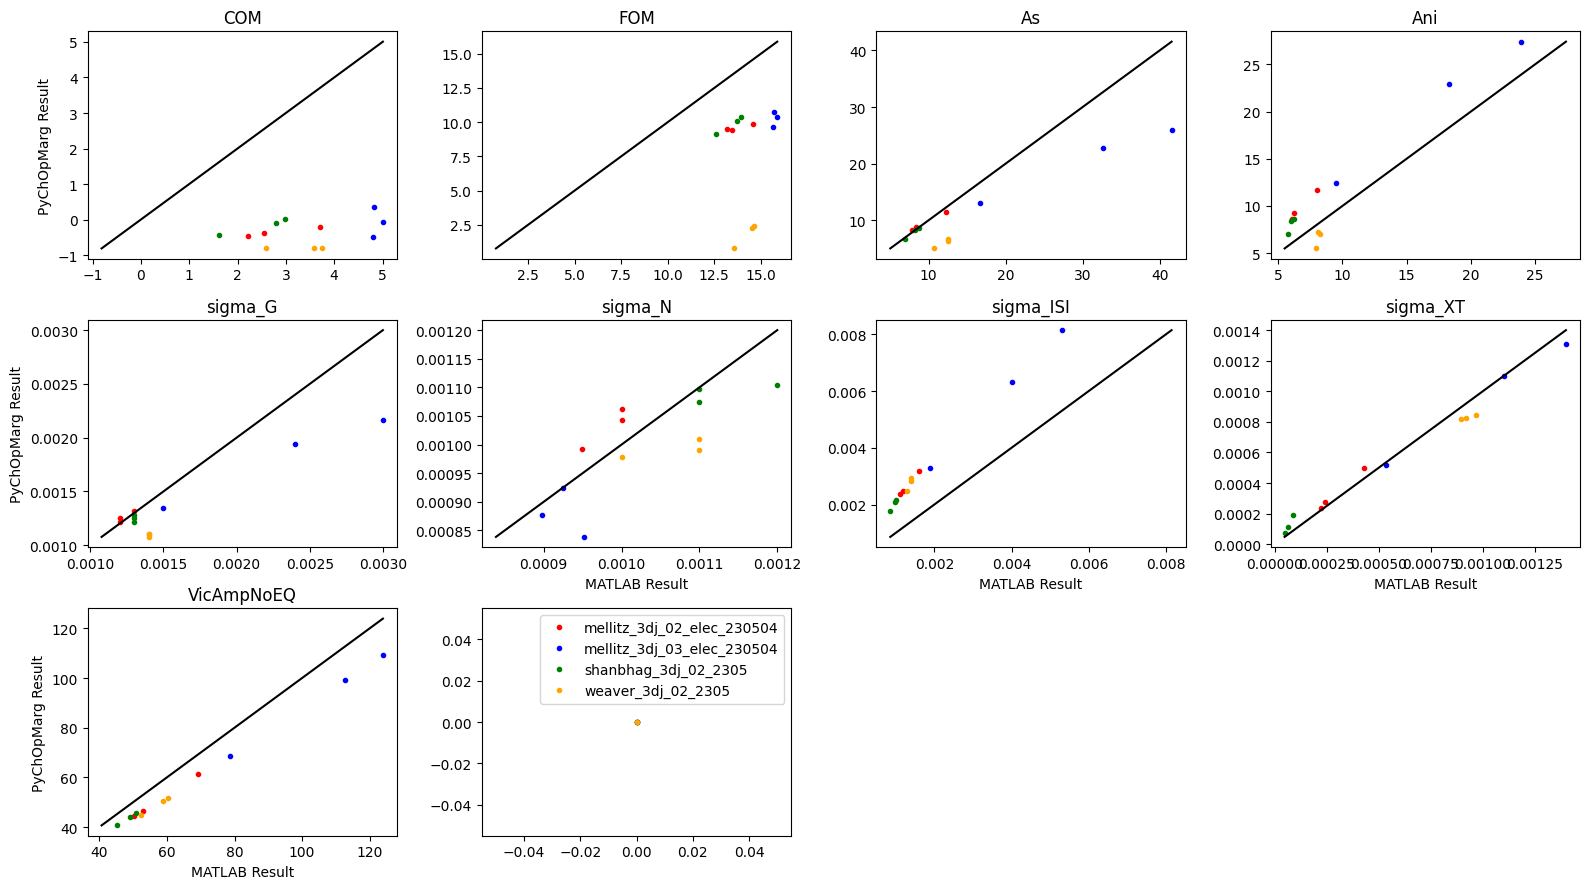

In [18]:
from math import ceil

comp_pairs = [
    ("channel_operating_margin_dB", "COM"),
    ("FOM", "FOM"),
    ("available_signal_after_eq_mV", "As"),
    ("Peak_ISI_XTK_and_Noise_interference_at_BER_mV", "Ani"),
    ("sgm_G", "sigma_G"),
    ("sgm_N", "sigma_N"),
    ("sgm_isi", "sigma_ISI"),
    ("sgm_xt", "sigma_XT"),
    ("peak_uneq_pulse_mV", "VicAmpNoEQ"),
]
nPlots = len(comp_pairs)

plot_groups = {}
grp_colors = ["red", "blue", "green", "orange", "purple", "yellow", "brown", "gray", "black"]
for grp, clr in zip(matlab_results.keys(), grp_colors):
    plot_xs = []
    plot_ys = []
    for n in range(nPlots):
        plot_xs.append([])
        plot_ys.append([])
    plot_groups.update({
        grp: {
            "color": clr,
            "plot_xs": plot_xs,
            "plot_ys": plot_ys
        }
    })

nCols = 4
nRows = ceil((nPlots + 1) / nCols)
lastRowCols = nPlots % nCols
plt.figure(figsize=(4 * nCols, 3 * nRows))

for grp in matlab_results.keys():
    matlab_rslts = matlab_results[grp]
    pychopmarg_rslts = theCOMs[grp]
    for chnl in matlab_rslts.keys():
        matlab_rslt = matlab_rslts[chnl]
        pcom_rslts = pychopmarg_rslts[chnl].com_rslts.copy()
        pfom_rslts = pychopmarg_rslts[chnl].fom_rslts.copy()
        pcom_rslts["FOM"] = pfom_rslts["FOM"]
        # pcom_rslts["sigma_XT"] = pfom_rslts["sigma_XT"]
        pcom_rslts["As"] *= 1e3
        pcom_rslts["Ani"] *= 1e3
        pcom_rslts["VicAmpNoEQ"] = max(pychopmarg_rslts[chnl].pulse_resps_noeq[0]) * 1e3
        for n, labels in enumerate(comp_pairs):
            plot_groups[grp]["plot_xs"][n].append(float(matlab_rslt["parse_rslts"][1][labels[0]]))
            plot_groups[grp]["plot_ys"][n].append(pcom_rslts[labels[1]])

for n in range(nPlots):
    row, col = divmod(n, nCols)
    plt.subplot(nRows, nCols, n + 1)
    xlabel = None
    ylabel = None
    if row == nRows - 1 or lastRowCols and row == nRows - 2 and col >= lastRowCols:
        xlabel = "MATLAB Result"
    if not (n % nCols):
        ylabel = "PyChOpMarg Result"
    min_val = 1e6
    max_val = -1e6
    for grp in matlab_results.keys():
        xs = plot_groups[grp]["plot_xs"][n]
        ys = plot_groups[grp]["plot_ys"][n]
        plt.plot(xs, ys, ".", color=plot_groups[grp]["color"], label=grp)
        _min_val = min(min(xs), min(ys))
        _max_val = max(max(xs), max(ys))
        if _min_val < min_val:
            min_val = _min_val
        if _max_val > max_val:
            max_val = _max_val
    plt.plot([min_val, max_val], [min_val, max_val], "k")
    plt.title(comp_pairs[n][1])
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

row, col = divmod(nPlots, nCols)
plt.subplot(nRows, nCols, nPlots + 1)
for grp in matlab_results.keys():
    plt.plot(0, 0, ".", color=plot_groups[grp]["color"], label=grp)
plt.legend()

plt.tight_layout()
plt.show()


Why are my `VicAmpNoEQ` values consistently slightly (approx. 12%) too low?!  
This only includes the channel and package models.
And those should both be "no brainers".  
Well, I guess I have my starting point for debugging the mismatch well identified. ;-)

- [x] Is this a `max()` vs. `loc_curs()` issue?

    ==> No, the code above is very clearly using `max()`.


#### Unequalized Pulse Responses

The disagreement in the `VicAmpNoEQ` case, above, is alarming, because that case only includes the channel and package models.  
And there's little room for misinterpretation of the model data and/or specification intent in either.

Let's plot those "pre-EQ" pulse responses and compare them...

**Note:** I've had to modify the MATLAB code to achieve this, as I wasn't able to import _Time Series_ data into Python.


In [34]:
import scipy.io as sio

# Construct a dummy COMs dict, to make use of our existing plotting routines.
matCOMs = {}
for grp, ch_set in tested_ch_sets:
    lbl = ch_set['THRU'][0].stem
    pyCOM = theCOMs[grp][lbl]
    matCOM = COM(com_params, ch_set, do_init=False)
    
    # Replace unequalized victim pulse response w/ MATLAB equivalent.
    path = f"test_results_C93/sbr_fir_ {grp}--{lbl}.mat"
    mat_file = sio.loadmat(path)
    mat_pulse_resps_noeq_t = mat_file.get('t_dbanas').flatten()
    mat_pulse_resps_noeq_v = mat_file.get('v_dbanas').flatten()
    py_pk_time = pyCOM.times[np.argmax(pyCOM.pulse_resps_noeq[0])]
    mat_pk_time = mat_pulse_resps_noeq_t[np.argmax(mat_pulse_resps_noeq_v)]
    mat_pk_delay = mat_pk_time - py_pk_time
    print(f"{grp}--{lbl}: {mat_pk_time} - {py_pk_time} = {mat_pk_delay}")
    # matCOM.t                 = mat_pulse_resps_noeq_t
    matCOM.t                 = mat_pulse_resps_noeq_t - mat_pk_delay
    matCOM.pulse_resps_noeq  = [mat_pulse_resps_noeq_v]
    # matCOM.com_rslts         = {"cursor_ix": np.argmax(mat_pulse_resps_noeq_v)}
    matCOM.com_rslts         = {"tISI": matCOM.t}
    # matCOM.com_rslts["tISI"] = matCOM.t

    if grp in matCOMs:
        matCOMs[grp].update({ch_set['THRU'][0].stem: matCOM})
    else:
        matCOMs.update({grp: {ch_set['THRU'][0].stem: matCOM}})

mellitz_3dj_02_elec_230504--KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_thru: 4.527941176470588e-09 - 4.511764705882353e-09 = 1.617647058823505e-11
mellitz_3dj_02_elec_230504--KRCA_wXTALK_MX_18_PCB-75-75_mm_FO-300-300_mm_CA-500_mm_thru: 6.1579411764705885e-09 - 6.141470588235294e-09 = 1.647058823529411e-11
mellitz_3dj_02_elec_230504--KRCA_wXTALK_MX_24_PCB-75-75_mm_FO-200-200_mm_CA-1000_mm_thru: 7.3820588235294115e-09 - 7.365588235294118e-09 = 1.6470588235293282e-11
mellitz_3dj_03_elec_230504--C2C_withXtalk_Mezz_2_PCB-60mm_25mm_thru: 1.1276470588235294e-09 - 1.111764705882353e-09 = 1.5882352941176404e-11
mellitz_3dj_03_elec_230504--C2C_withXtalk_Mezz_10_PCB-200mm_60mm_thru: 2.203235294117647e-09 - 2.1873529411764706e-09 = 1.5882352941176404e-11
mellitz_3dj_03_elec_230504--C2C_withXtalk_Mezz_3_PCB-95mm_25mm_thru: 1.3426470588235294e-09 - 1.326764705882353e-09 = 1.5882352941176404e-11
shanbhag_3dj_02_2305--KR_1mCabledBP_TP0TP5_27p4dB_CabledHost_7p85dB_THRU: 9.551176470588236e-0

              mellitz_3dj_02_elec_230504                   mellitz_3dj_03_elec_230504                      shanbhag_3dj_02_2305                          weaver_3dj_02_2305              

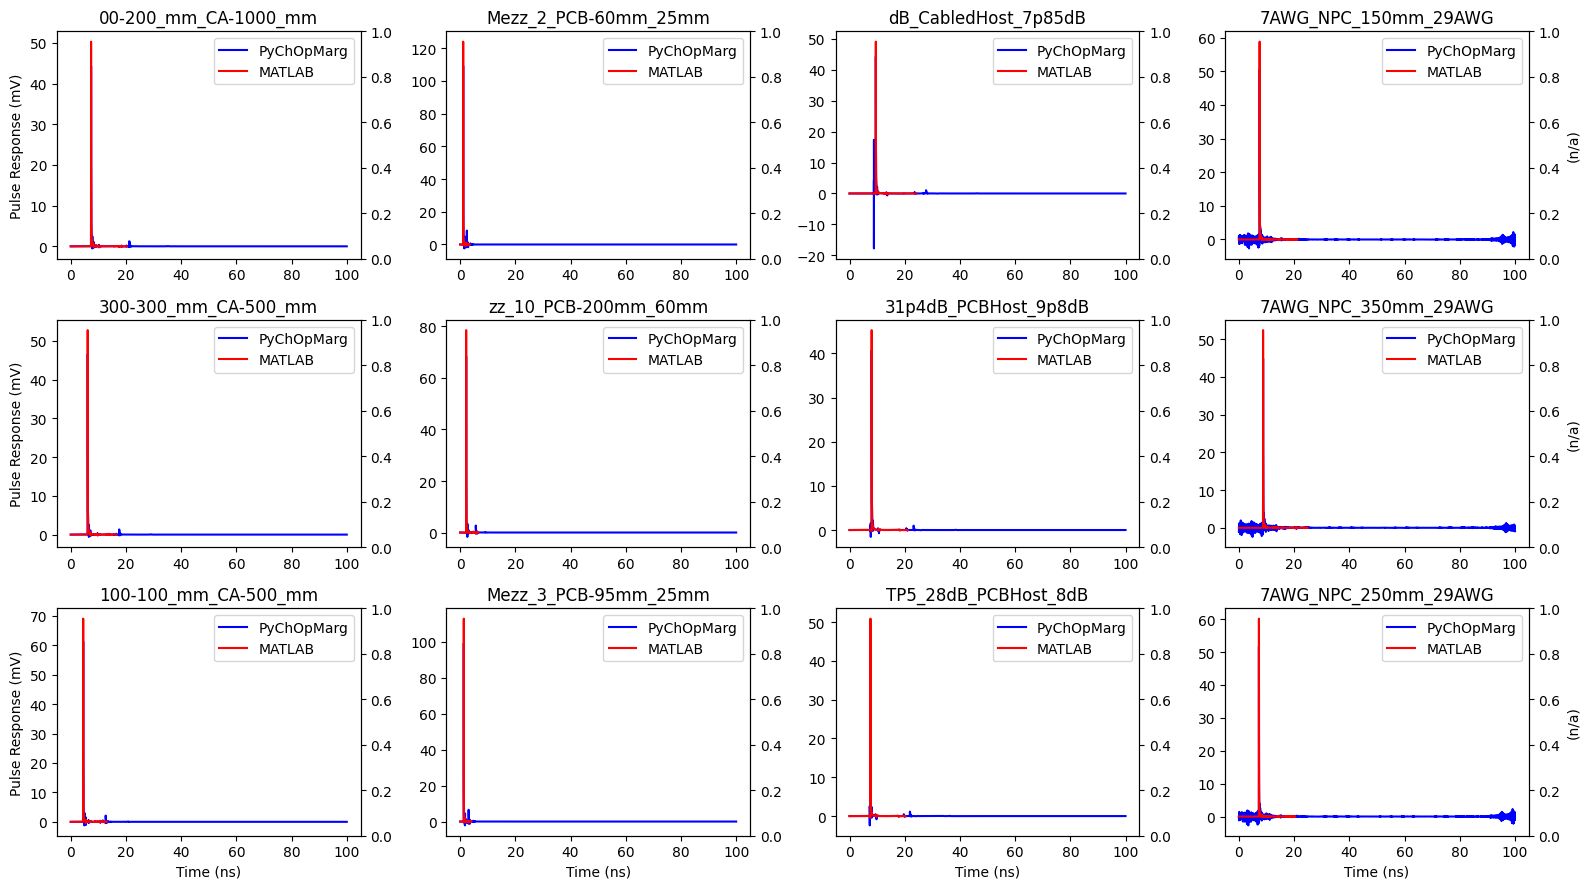

              mellitz_3dj_02_elec_230504                   mellitz_3dj_03_elec_230504                      shanbhag_3dj_02_2305                          weaver_3dj_02_2305              

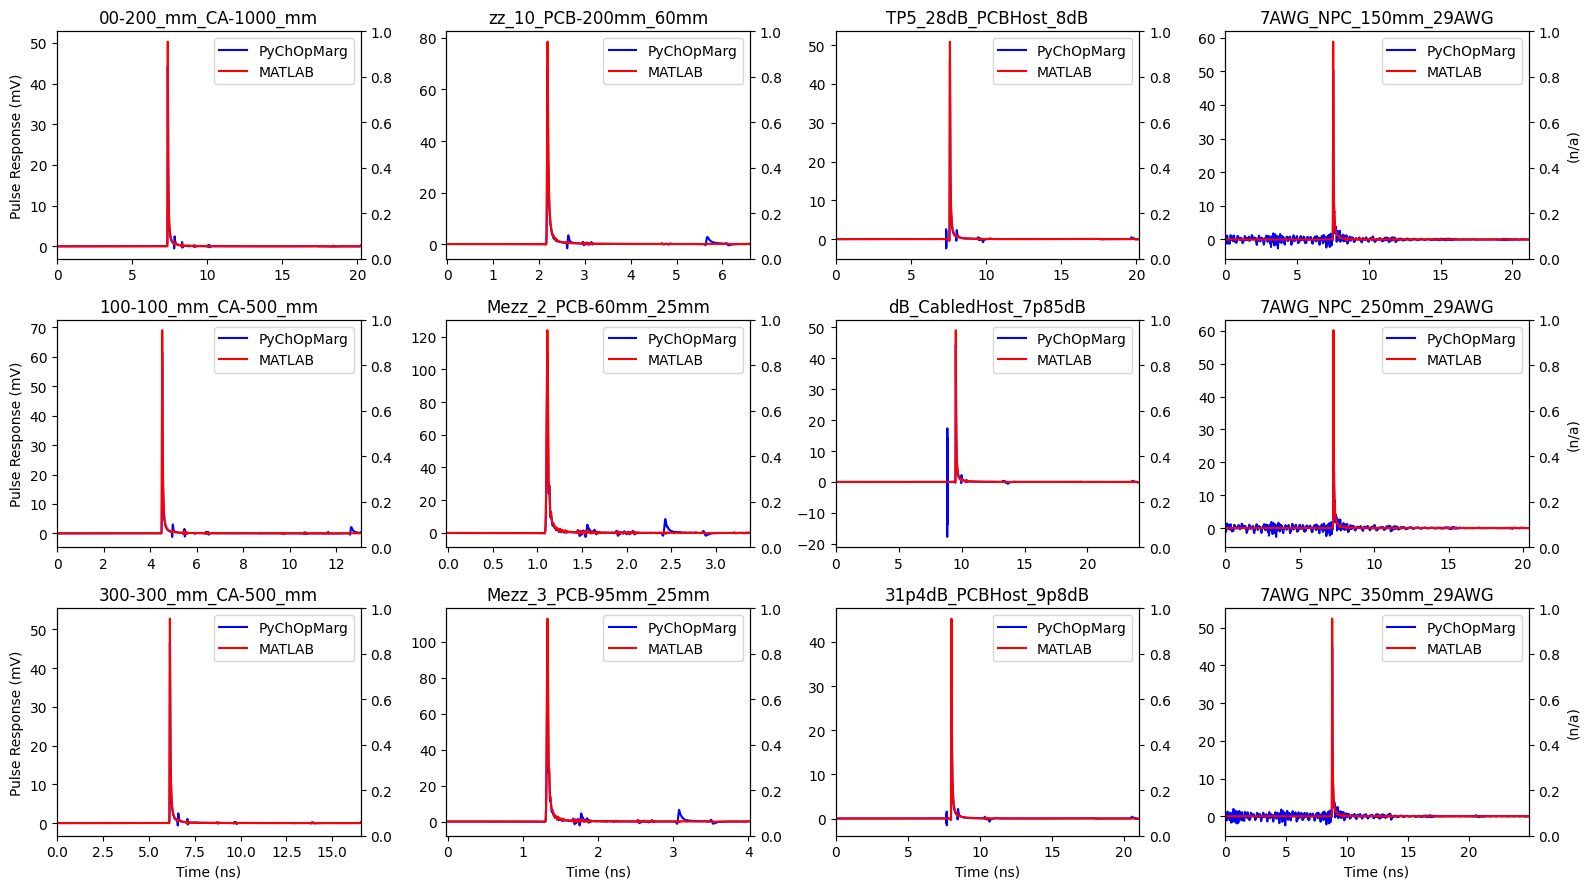

              mellitz_3dj_02_elec_230504          

C:\Users\davibana\AppData\Local\Temp\ipykernel_24400\1523264064.py:96: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.axis(xmin=xmin, xmax=xmax)


         mellitz_3dj_03_elec_230504                      shanbhag_3dj_02_2305                          weaver_3dj_02_2305              

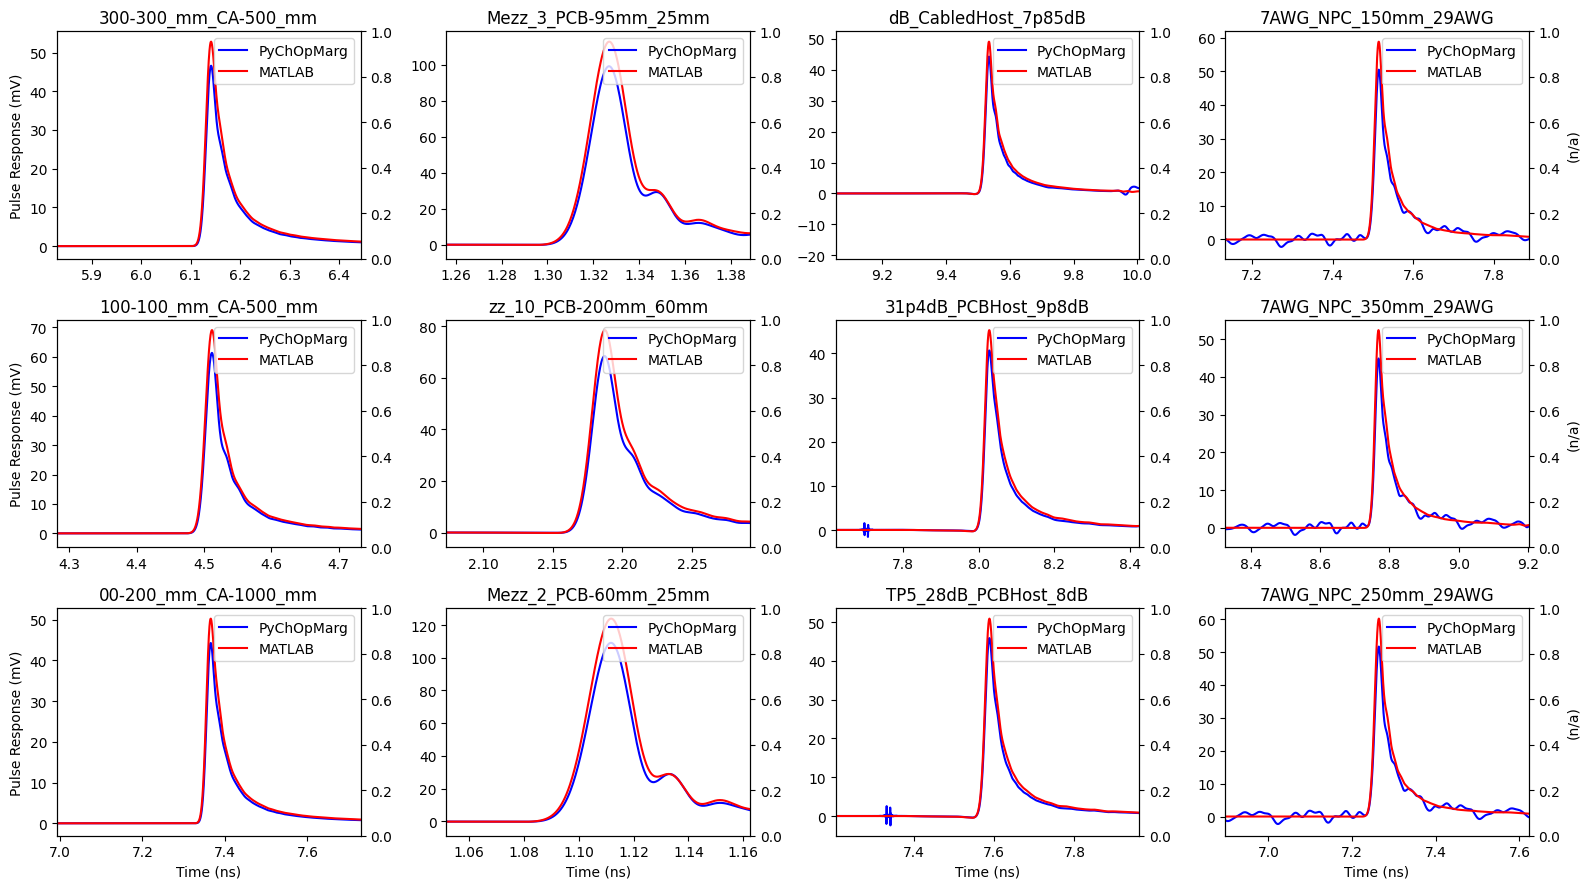

In [39]:
for zoom in [ZoomMode.FULL, ZoomMode.ISI, ZoomMode.PULSE]:
    plot_group_samps(
        plot_pulse_resps_gen(zoom, noeq=True),
        "Time (ns)",
        ("Pulse Response (mV)", "(n/a)"),
        [("PyChOpMarg", {"color": "blue"}, theCOMs),
         ("MATLAB",     {"color": "red"},  matCOMs),
        ],
        dx=4,
        dy=3
    )

In [ ]:
raise RuntimeError("End of notebook.")

## MMSE vs. PRZF

Let's run some comparisons between the old PRZF and new MMSE methods of Rx FFE tap weight optimization.


### COM

Let's compare our "MMSE vs. PRZF" COM results to Adam's, checking his conclusion that MMSE is better.


In [ ]:
for grp in list(theCOMs.keys()):
    for lbl in list(theCOMs[grp].keys()):
        plt.plot(_theCOMs[grp][lbl].com_rslts["COM"], theCOMs[grp][lbl].com_rslts["COM"], ".b")
ldata = range(-1, 8)
plt.plot(ldata, ldata, "gray")
plt.title("COM - MMSE vs. PRZF")
plt.ylabel("COM - MMSE (dB)")
plt.xlabel("COM - PRZF (dB)")
plt.grid()
plt.show()


I suppose there's a slight preponderance of points above the line, indicating that MMSE is outperforming PRZF.  
However, MMSE's superior performance lies in the region _above_ 3 dB.  
Where we actually need MMSE to shine is _below_ 3 dB, hopefully turning some failing cases into passing cases.

My results don't match Adam Healey's very well:

![Adam Healy Jan. 2024](Adams_Comparison.png)


### FOM

Here, we compare the _Figure of Merrit_ (FOM) values used to select optimum tap weight values.

The linear regression is also plotted, for reference.

In [ ]:
from scipy.stats import linregress

xs = []
ys = []
for grp in list(theCOMs.keys()):
    for lbl in list(theCOMs[grp].keys()):
        x = _theCOMs[grp][lbl].fom_rslts["FOM"]
        y = theCOMs[grp][lbl].fom_rslts["FOM"]
        plt.plot(x, y, ".b")
        xs.append(x)
        ys.append(y)

rslt = linregress(xs, ys)
m = rslt.slope
b = rslt.intercept
stderr = rslt.intercept_stderr

plt.plot(xs, list(map(lambda x: m*x + b, xs)), "gray")
plt.text(np.mean(xs), np.mean(ys), f"y = {m:4.2f} x + ({b:4.2f} +/- {stderr:4.2f})")
plt.title("FOM - MMSE vs. PRZF")
plt.ylabel("FOM - MMSE (dB)")
plt.xlabel("FOM - PRZF (dB)")
plt.show()


Overall, the linear regression is pretty good.  
However, note that the new MMSE FOM runs over 7 dB lower than the old PRZF equivalent.

### Victim Pulse Response

Let's plot the victim pulse response and compare.  
We'll include the ISI for the MMSE case, as a visual indicator of the quality of the Rx FFE tap weight optimization process.

In [ ]:
def plot_pulse_resps2(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot the post-FFE pulse responses."
    
    ui = 1 / com.fb
    nspui = com.nspui
    curs_ix = com.com_rslts["cursor_ix"]
    first_ix = curs_ix - com.nRxPreTaps * nspui
    last_ix = first_ix + com.nRxTaps * nspui
    ix_isi = range(first_ix, last_ix, nspui)
    clr = opts["color"]
    # ax1.plot(com.times * 1e9, com.com_rslts["pulse_resps"][0] * 1e3, label=nm, color=clr)
    ax1.plot(com.times * 1e9, com.pulse_resps_noeq[0] * 1e3, label=nm, color=clr)
    ax1.legend(loc="upper right")
    if nm == "MMSE":
        ax1.plot(com.com_rslts["tISI"] * 1e9, com.com_rslts["hISI"] * 1e3, "xk")
        for _n, _ix in enumerate(ix_isi):
            _t = com.times[_ix]
            if _n == com.nRxPreTaps:  # cursor
                plt.axvline(_t * 1e9, color=clr, linestyle="-")
            else:
                plt.axvline(_t * 1e9, color=clr, linestyle=":")
        # ax1.axis(xmin=(com.times[first_ix] - ui/2) * 1e9, xmax=(com.times[last_ix] - ui/2) * 1e9)
    ax1.grid()
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(
    plot_pulse_resps2,
    "Time (ns)",
    ("Pulse Response (mV)", "(n/a)"),
    [("MMSE", {"color": "blue"}, theCOMs),
     ("PRZF", {"color": "red"}, _theCOMs),
    ],
    dx=4,
    dy=3
)


**Observations:**

1. In general, there appears to be excessive ringing after the cursor in the PRZF case.
2. The MMSE case seems to consistently yield a smaller _Full Width at Half Maximum_ (FWHM), although the difference is slight.


### Rx FFE Tap Weights

Let's compare the Rx FFE tap weights...

In [ ]:
print("Final Rx FFE Tap Weights (solid) and pre-FFE Pulse Response (dotted):\n")

def plot_tap_weights(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot Rx FFE tap weights and pre-FFE pulse response."
    nTaps    = com.nRxTaps
    if not nTaps:
        nTaps = 1
    nPreTaps = com.nRxPreTaps
    tap_ix   = np.arange(nTaps) + 1
    clr = opts["color"]
    ax1.plot(tap_ix, com.rx_taps, label=nm, color=clr)
    pr_samps = com.fom_rslts["pr_samps"]
    curs_loc = np.argmax(pr_samps)
    pr_samps = pr_samps[curs_loc - nPreTaps: curs_loc - nPreTaps + nTaps]
    ax2.plot(tap_ix[:len(pr_samps)], pr_samps * 1e3, ":", color=clr)
    plt.title(f"{lbl[-25:-5]}")
    ax1.set_xlabel("Tap #")
    ax1.set_ylabel("Weight")
    ax2.set_ylabel("Pulse Response (mV)")
    plt.axis(xmin=1, xmax=15)
    ax1.xaxis.set_major_locator(MultipleLocator(1))
    ax1.grid(which='major', axis='x')
    ax2.grid(which='major', axis='y')
    ax1.legend()

plot_group_samps(
    plot_tap_weights,
    "Tap #",
    ("Weight", "Pulse Response (mV)"),
    [("MMSE", {"color": "blue"}, theCOMs),
     ("PRZF", {"color": "red"}, _theCOMs),
    ],
    dx=4,
    dy=3
)


**Observations:**

1. The post-cursor tap weights in the PRZF case appear to be consistently over-aggressive.

    - That seems consistent with the excessive post-cursor ringing in the victim pulse response noticed above.
  
**Questions:**

1. What is the cause of the marked difference in pre-FFE pulse response in some cases above?

    - Is this just the result of slight differences in cursor location selection?


#### Cursor Tap Weight Comparison

Here, we plot the cursor tap weights for the MMSE case, as a function of their PRZF equivalents, to get a sense for how the two optimization approaches differ in this regard.

In [ ]:
min_val = 1000
max_val = 0
for grp in theCOMs.keys():
    for lbl in theCOMs[grp].keys():
        com = theCOMs[grp][lbl]
        _com = _theCOMs[grp][lbl]
        com_val  = com.rx_taps[com.nRxPreTaps]
        _com_val = _com.rx_taps[_com.nRxPreTaps]
        # plt.plot(_com.rx_taps[_com.nRxPreTaps], com.rx_taps[com.nRxPreTaps], "b.")
        plt.plot(_com_val, com_val, "b.")
        if com_val < min_val:
            min_val = com_val
        if _com_val < min_val:
            min_val = _com_val
        if com_val > max_val:
            max_val = com_val
        if _com_val > max_val:
            max_val = _com_val
ldata = [min_val, max_val]
plt.plot(ldata, ldata, "gray")
plt.title("Rx FFE Cursor Tap Weight Comparison - MMSE vs. PRZF")
plt.xlabel("PRZF w0")
plt.ylabel("MMSE w0")
plt.show()


**Observations:**

1. The MMSE approach consistently yields larger cursor tap weight values.


### Rx FFE Frequency Response

Here, we plot the frequency response of the Rx FFE, again comparing the PRZF and MMSE cases.

In [ ]:
def plot_Hffe(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot the Rx FFE transfer functions."
    Hffe = calc_Hffe(com.freqs, 1/com.fb, np.array(com.rx_taps).flatten(), com.nRxTaps - com.nRxPreTaps - 1, hasCurs=True)
    Hffe_2 = abs(rfft(from_irfft(irfft(np.abs(Hffe) ** 2), com.t_irfft, com.times, com.nspui)))
    clr = opts["color"]
    _f = np.linspace(0, 0.5, len(Hffe_2))
    ax1.plot(_f, 20*np.log10(abs(Hffe_2)), label=nm, color=clr)
    ax1.grid()
    ax1.legend()  # loc="lower left")
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(plot_Hffe, "Frequency (fBaud.)", ("|Hffe| (dB)", "(n/a)"), [("MMSE", {"color": "blue"}, theCOMs),
                                                                             ("PRZF", {"color": "red"},  _theCOMs)])


### Noise & Interference PMFs

Here, we look at the difference in the noise and interference PMFs used to calculate $A_{ni}$.


In [ ]:
def plot_pmfs(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot various components of the noise & interference PMF."
    ax1.plot([0, 1], [0, 0], label=nm, color="gray", linestyle=opts["linestyle"])  # Just for legend.
    if nm == "PRZF":
        ax1.legend(loc="lower left")
    y = com.com_rslts["y"]
    ax1.semilogy(y * 1e3, com.com_rslts['pJ'],   label="pJ",   color="blue",   linestyle=opts["linestyle"])
    ax1.semilogy(y * 1e3, com.com_rslts['pG'],   label="pG",   color="orange", linestyle=opts["linestyle"])
    ax1.semilogy(y * 1e3, com.com_rslts['pISI'], label="pISI", color="green",  linestyle=opts["linestyle"])
    ax1.semilogy(y * 1e3, com.com_rslts['pXT'],  label="pXT",  color="red",    linestyle=opts["linestyle"])
    ax1.axis(ymin=1e-20, ymax=1)
    ax1.grid()
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(
    plot_pmfs,
    "y (mV)",
    ("p[y]", "(n/a)"),
    [("MMSE", {"linestyle": "solid"},  theCOMs),
     ("PRZF", {"linestyle": "dashed"}, _theCOMs),
    ],
    dx=4,
    dy=3
)


In [ ]:
def plot_Rx_freq(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot constituents of `varN`, to better understand the wide variance of `pG` above."
    ax1.plot([0, 1], [0, 0], label=nm, color="gray", linestyle=opts["linestyle"])  # Just for legend.
    if nm == "PRZF":
        ax1.legend(loc="lower left")
    ax1.semilogx(com.freqs / 1e9, 20 * np.log10(np.abs(com.Hr)),   label="Hr",   color="blue",   linestyle=opts["linestyle"])
    ax1.semilogx(com.freqs / 1e9, 20 * np.log10(np.abs(com.Hctf)), label="Hctf", color="red",    linestyle=opts["linestyle"])
    Hrx = calc_Hffe(
        com.freqs, 1 / com.fb, array(com.rx_taps).flatten(),
        com.nRxTaps - com.nRxPreTaps - 1, hasCurs=True)
    ax1.semilogx(com.freqs / 1e9, 20 * np.log10(np.abs(Hrx)),  label="Hffe", color="orange", linestyle=opts["linestyle"])
    # ax1.axis(ymin=1e-20, ymax=1)
    ax1.grid()
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(
    plot_Rx_freq,
    "Frequency (GHz)",
    ("|H(f)|", "(n/a)"),
    [("MMSE", {"linestyle": "solid"},  theCOMs),
     ("PRZF", {"linestyle": "dashed"}, _theCOMs),
    ],
    dx=4,
    dy=3
)


In [ ]:
print("All 'Sigma_?' values have units of mV.")
print("\nGroup\tChannel\t\t\t\t\t  COM (dB)   FOM (dB)      As (mV)  Ani (mV)   Sigma_G    Sigma_N")
print("=" * 113)
for grp in theCOMs.keys():
    print(grp)
    for lbl in theCOMs[grp].keys():
        print(f"\t{lbl[-40:]:41s}", end="")
        com  = theCOMs[grp][lbl]
        print(f"  {com.com_rslts['COM']:4.1f}       {com.fom_rslts['FOM']:4.1f}        {com.com_rslts['As'] * 1e3:7.1f}   {com.com_rslts['Ani'] * 1e3:7.1f}     {com.com_rslts['sigma_G'] * 1e3:4.2f}\t   {com.com_rslts['sigma_N'] * 1e3:4.2f}")


**Observations:**

1. The PRZF case yields consistently larger ISI than the MMSE case.

    - This seems consistent w/ the pulse response and tap weight plots, above.
  
2. The dominant factor seems to be the Rx thermal noise ($\eta_0$), which is reflected in the `pG` curve in the plots above.

    - In the cases where there exists significant discrepancy between the two cases, it is the MMSE case that shows larger values.  
      And that seems consistent w/ the generally higher FFE gain, particularly at the upper end of the frequency band, as revealed in the _Rx FFE Frequency Response_ plots, above.


## MMSE Details

### COM vs. FOM

Here, we compare COM to FOM.

In [ ]:
names     = []
com_vals  = []
com_rslts = []
for grp, d in theCOMs.items():
    for lbl, theCOM in d.items():
        names.append(grp + ":" + lbl)
        com_vals.append(theCOM.com_rslts['COM'])
        com_rslts.append([
            theCOM.com_rslts['As'],
            theCOM.com_rslts['Ani'],
            theCOM.fom_rslts['FOM'],
            theCOM.com_rslts['sigma_ISI'],
            theCOM.fom_rslts['sigma_XT'],
            theCOM.fom_rslts['sigma_J'],
            theCOM.com_rslts['sigma_G'],
            theCOM.com_rslts['sigma_Tx'],
            theCOM.com_rslts['sigma_N'],
            1 / (fwhm(theCOM.pulse_resps_noeq[0]) * theCOM.times[1]),  # raw channel bandwidth
            reflectivity(theCOM.pulse_resps_noeq[0]) * theCOM.times[1],
        ])


In [ ]:
fom = np.array(list(map(lambda tup: tup[2], com_rslts)))
plt.figure(figsize=(6, 4))
plt.plot(fom, com_vals, ".")
plt.plot(fom, fom + 0.0)
plt.title("COM vs. FOM")
plt.xlabel("FOM (dB)")
plt.ylabel("COM (dB)")
plt.grid()
plt.show()


There seems to be pretty good correlation between COM and FOM, above zero.  
And the range of FOM values is consistent w/ Adam's plots of COM values.  
However, the COM values appear to be bounded from below by zero, which is incorrect.

### Tabulated Results

The tabulated results below suggest the following:

1. The COM & FOM values agree fairly well, both with each other and Adam's reported range of values for these channels, for _positive_ values of both.
However, the agreement falls apart for negative FOM values.
Indeed, the COM values seem to be bounded from below by zero.
And that is incorrect.

    - The range of COM values in Adam's plots is about: [-3, 6].
    - Note the FOM numbers, below, fit into that range quite nicely.
  
3. The other noise components are dwarfed by `Sigma_ISI`.

    - The next largest component, `Sigma_Tx`, is down by an order of magnitude!
    - The rest barely even register; why?


In [ ]:
print("All 'Sigma_?' values have units of mV.")
print("\nGroup\tChannel\t\t\t\t\t  COM (dB)   FOM (dB)    ME (mV)   As (mV)  Ani (mV)  Sigma_Tx\t Sigma_ISI   Sigma_J\tSigma_Xt   Sigma_N")
print("=" * 154)
for grp in theCOMs.keys():
    print(grp)
    for lbl in theCOMs[grp].keys():
        print(f"\t{lbl[-40:]:41s}", end="")
        com  = theCOMs[grp][lbl]
        print(f"  {com.com_rslts['COM']:4.1f}       {com.fom_rslts['FOM']:4.1f}        {np.sqrt(com.fom_rslts['mse']) * 1e3:.1g}   {com.com_rslts['As'] * 1e3:7.1f}   {com.com_rslts['Ani'] * 1e3:7.1f}     {com.fom_rslts['sigma_Tx'] * 1e3:4.2f}\t   {com.fom_rslts['sigma_ISI'] * 1e3:4.2f}      {com.fom_rslts['sigma_J'] * 1e3:4.2f}\t  {com.fom_rslts['sigma_XT'] * 1e3:4.2f}       {com.fom_rslts['sigma_N'] * 1e3:4.2f}")


### Pre-EQ Pulse Responses

Here are the victim pulse responses w/o EQ.

In [ ]:
def plot_pulse_resps_noeq(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot the pre-EQ pulse responses."
    
    # ui = 1 / com.fb
    # nspui = com.nspui
    # curs_ix = com.com_rslts["cursor_ix"]
    # first_ix = curs_ix - com.nRxPreTaps * nspui
    # last_ix = first_ix + com.nRxTaps * nspui
    # ix_isi = range(first_ix, last_ix, nspui)
    clr = opts["color"]
    ax1.plot(com.times * 1e9, com.pulse_resps_noeq[0] * 1e3, label=nm, color=clr)
    # ax1.legend(loc="upper right")
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(
    plot_pulse_resps_noeq,
    "Time (ns)",
    ("Pulse Response (mV)", "(n/a)"),
    [("MMSE", {"color": "blue"}, theCOMs),
    ],
    dx=4,
    dy=3
)


### Noise & Interf. PMF Plots

Let's plot the various components of `py` and see if anything suspicious shows up...


In [ ]:
def plot_pys(com: COM, grp: str, lbl: str, nm: str, clr: str, ax1: Any, ax2: Any) -> None:
    """
    Plot various components of the noise & interference PMF.

    Args:
        com: The COM object to use for plotting.
        grp: The channel _group_ name.
        lbl: The channel _set_ name.
        nm: The COM group _name_ (i.e. - "MMSE" vs. "PRZF", for instance).
        clr: The name of the _color_ to use for plotting.
        ax1: Primary y-axis.
        ax2: Secondary y-axis.

    Returns:
        None

    Notes:
        1. The calling signature of this function is defined by the `plot_group_samps()` function.
            (See the _Imports & Utilities_ section, above.)
    """

    y = com.com_rslts["y"]
    ax1.semilogy(y * 1e3, com.com_rslts['pJ'], label="pJ")
    ax1.semilogy(y * 1e3, com.com_rslts['pG'], label="pG")
    ax1.semilogy(y * 1e3, com.com_rslts['py'], label="pISI")
    ax1.semilogy(y * 1e3, com.com_rslts['pXT'], label="pXT")
    ax1.axis(ymin=1e-20, ymax=1)
    ax1.grid()
    ax1.legend(loc="lower left")
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(plot_pys, "y (mV)", ("p[y]", "(n/a)"), [("MMSE", "blue", theCOMs),])


The ISI is just too extreme.
At 1e-4 (our DER0), we're already out about 500 mV!
That's too much.
Something must be wrong w/ the ISI calculation.

### Power Spectral Density Plots

In the new MMSE approach to Rx FFE tap weight optimization, the noise and interference _power spectral densities_ (PSDs) play a primary role.  
Let's plot them and see if anything suspicious shows up...


### Noise PSDs

Here, we plot the noise _Power Spectral Densities_ (PSDs).


Well, those all seem to be, at least, in the same order of magnitude range as what Adam Healey reported in his January 2024 presentation to the 802.3dj task force:

![Adam Healey's PSD Plots](Adams_PSDs.png)


#### Autocorrelation Vectors

As a final check, let's plot the `Rn` for the test cases above.

In [ ]:
plt.figure(figsize=(12, 5))
for grp in theCOMs.keys():
    for lbl in theCOMs[grp].keys():
        com  = theCOMs[grp][lbl]
        theNoiseCalc = com.theNoiseCalc
        Rn = np.abs(theNoiseCalc.Rn())
        assert all(Rn >= 0)
        assert not any(np.isnan(Rn))
        ix = np.arange(len(Rn)) - len(Rn) // 2
        plt.plot(ix, fftshift(np.sqrt(Rn)) * 1e3, label=grp[:14]+"...:..."+lbl[-26:])
plt.title("Autocorrelation Vectors (mV)")
plt.xlabel("Vector Index")
# plt.axis(ymin=-200, ymax=-135)
plt.grid()
plt.legend()
plt.show()


Well, those certainly look like autocorrelation vectors, but I don't really know how to judge whether the magnitude makes sense.
Let's generate their noise PDFs and look at those...

#### Rn PDFs

Here, we use the autocorrelation vectors above to generate noise PDFs, just like in the COM calculation for $A_{ni}$.

In [ ]:
from pychopmarg.utility import delta_pmf

plt.figure(figsize=(12, 5))
for grp in theCOMs.keys():
    for lbl in theCOMs[grp].keys():
        com = theCOMs[grp][lbl]
        theNoiseCalc = com.theNoiseCalc
        x, py = delta_pmf(np.sqrt(np.abs(theNoiseCalc.Rn())))
        plt.plot(x * 1e3, py, label=grp[:14]+"...:..."+lbl[-26:])
plt.title("Noise Amplitude PMF")
plt.xlabel("Noise Amplitude (mV)")
plt.grid()
plt.legend()
plt.show()


In [ ]:
def plot_psds(com: COM, grp: str, lbl: str, nm: str, clr: str, ax1: Any, ax2: Any) -> None:
    "Plot various components of the noise & interference PSD."
    theNoiseCalc = com.theNoiseCalc
    Srn = theNoiseCalc.Srn
    Sxn = np.sum(np.array(list(map(theNoiseCalc.Sxn, theNoiseCalc.agg_pulse_resps))), axis=0)
    Stn = theNoiseCalc.Stn
    Sjn = theNoiseCalc.Sjn

    Hffe = calc_Hffe(theNoiseCalc.f, theNoiseCalc.Tb, np.array(com.rx_taps).flatten(), com.nRxTaps - com.nRxPreTaps - 1, hasCurs=True)
    Hffe_2 = abs(rfft(theNoiseCalc.from_irfft(irfft(np.abs(Hffe) ** 2))))
    # The next step seems necessary, in order to match Adam's results, below.
    Hffe_2 /= max(Hffe_2)  # Normalize to enforce passivity. (Is that correct? Should I normalize for unity d.c. gain, instead?)
    
    _f = np.linspace(0, 0.5, len(Srn))
    ax1.plot(_f, dBm_Hz(Srn * Hffe_2), label="Srn", color="blue")
    ax1.plot(_f, dBm_Hz(Sxn * Hffe_2), label="Sxn", color="orange")
    ax1.plot(_f, dBm_Hz(Stn * Hffe_2), label="Stn", color="purple")
    ax1.plot(_f, dBm_Hz(Sjn * Hffe_2), label="Sjn", color="green")
    plt.title(f"{grp[:12]}:{lbl[-15:]}")

    ax1.axis(ymin=-200, ymax=-140)
    ax1.grid()
    ax1.legend(loc="lower left")
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(plot_psds, "Frequency (fBaud.)", ("PSD (dBm/Hz)", "(n/a)"), [("MMSE", "blue", theCOMs),])


Comparing the above to Adam's reported values (See plot below, taken from his Jan. 2024 presentation.) shows pretty good agreement.

**However, note that I've had to _normalize_ the FFE transfer function, above, in order to get this agreement!**

I'm _not_ doing that in my noise & interference calculation code.
And now I'm wondering if this is the source of my extreme ISI.

![Adam Healey's PSD Plots](Adams_PSDs.png)


### Hffe Plots

The revelation, above, that $H_{ffe}$ needs to be normalized for passivity, in order to get a good match to Adam's reported results, casts suspicion on my Rx FFE tap weight results.
Let's get the transfer functions plotted here, for the record.


In [ ]:
print("\nGroup\tChannel\t\t\t\t\t\tRx FFE Cursor Tap Weight")
print("=" * 80)
for grp in theCOMs.keys():
    print(grp)
    for lbl in theCOMs[grp].keys():
        print(f"\t{lbl[-40:]:41s}", end="")
        com  = theCOMs[grp][lbl]
        print(f"\t\t{com.rx_taps[com.nRxPreTaps]:4.1f}")


In [ ]:
def plot_Hffe(com: COM, grp: str, lbl: str, nm: str, clr: str, ax1: Any, ax2: Any) -> None:
    "Plot the Rx FFE transfer functions."
    theNoiseCalc = com.theNoiseCalc

    Hffe = calc_Hffe(com.freqs, 1/com.fb, np.array(com.rx_taps).flatten(), com.nRxTaps - com.nRxPreTaps - 1, hasCurs=True)
    Hffe_2 = abs(rfft(theNoiseCalc.from_irfft(irfft(np.abs(Hffe) ** 2))))
    # The next step seems necessary, in order to match Adam's results, below.
    # Hffe_2 /= max(Hffe_2)  # Normalize to enforce passivity. (Is that correct? Should I normalize for unity d.c. gain, instead?)
    
    _f = np.linspace(0, 0.5, len(Hffe_2))
    ax1.plot(_f, 10*np.log10(Hffe_2), label="Raw", color="blue")
    # ax1.plot(_f, 10*np.log10(Hffe_2 / max(Hffe_2)), label="Norm.", color="red")
    plt.title(f"{grp[:12]}:{lbl[-15:]}")

    ax1.grid()
    # ax1.legend(loc="lower left")
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(plot_Hffe, "Frequency (fBaud.)", ("|Hffe| (dB)", "(n/a)"), [("MMSE", "blue", theCOMs),])


### Lambda vs. MSE/varX

The Lagrange multiplier value, $\lambda$, from the MMSE matrix equation solution for the optimum Rx FFE tap weights is supposed to equal the _minimum mean squared error_ (MMSE) normalized to the average signal power, $\sigma_X^2$.  
Let's see if that holds true...

In [ ]:
print("\nGroup\tChannel\t\t\t\t\t   Lambda     MSE/varX    Hit b limit    Hit w limit")
print("=" * 100)
for grp in theCOMs.keys():
    print(grp)
    for lbl in list(theCOMs[grp].keys())[:3]:
        print(f"\t{lbl[-40:]:41s}", end="")
        com  = theCOMs[grp][lbl]
        L = com.com_params.L
        varX = (L**2 - 1) / (3 * (L - 1)**2)  # (93A-29)
        print(f"   {com.mmse_rslt['lambda']:5.3f}\t{com.mse / varX:5.3f}\t    {com.mmse_rslt['hit_b_limit']}\t    {(com.rx_taps > com.rx_taps_max).any() or (com.rx_taps < com.rx_taps_min).any()}")


That large difference between `Lambda` and `MSE/varX` is suspicious.  
Adam claims that they should be roughly equal.


### Passive Rx FFE

The results above strongly suggest that I should be normalizing the Rx FFE tap weights for passivity.  
Let's try that on a few randomly selected channel sets...

In [ ]:
_tested_ch_sets = sample(ch_sets, 9)  # Random selection w/ no duplication; used for quick-turn debugging sessions.
nTests = len(_tested_ch_sets)
print(f"{nTests} channels selected for testing. (Approximately {nTests * 30 / 60: .1f} minutes.)")
# theCOMs_FFE = run_com(_tested_ch_sets, params)


### Rx FFE Normalization

Here, we compare the 3 different available modes of Rx FFE tap weight normalization during optimization:

1. (`P8023dj`) As per the standard (D1.2).
2. (`Scaled`) Uniformly and minimally scaled, to meet limits.
3. (`Unaltered`) Unchanged from constrained optimization solution.


In [ ]:
# `theCOMs` already contains the "UnitDcGain" case.
theCOMs_UnitDcGain = theCOMs
theCOMs_Unaltered = run_com(tested_ch_sets, params, norm_mode=NormMode.Unaltered)
theCOMs_Scaled    = run_com(tested_ch_sets, params, norm_mode=NormMode.Scaled)
theCOMs_P8023dj   = run_com(tested_ch_sets, params, norm_mode=NormMode.P8023dj)


In [ ]:
with open("theCOMs_Unaltered.pickle", "wb") as dump_file:
    pickle.dump(theCOMs_Unaltered, dump_file)
with open("theCOMs_Scaled.pickle", "wb") as dump_file:
    pickle.dump(theCOMs_Scaled, dump_file)
with open("theCOMs_P8023dj.pickle", "wb") as dump_file:
    pickle.dump(theCOMs_P8023dj, dump_file)


#### Tabulated Results

Here, we look at the difference in certain key metrics of the analysis.


In [ ]:
print("Data triplets are: (P8023dj) / (Unaltered) / (Scaled).")
print("\nGroup\tChannel\t\t\t\t\t     COM (dB)\t\t  FOM (dB)\t\t   Sigma_ISI (mV)\t\tLambda\t\t\t\tMSE/varX")
print("=" * 173)
for grp in theCOMs.keys():
    print(grp)
    for lbl in theCOMs[grp].keys():
        print(f"\t{lbl[-40:-5]:36s}", end="")

        com   = theCOMs[grp][lbl]
        com_u = theCOMs_Unaltered[grp][lbl]
        com_s = theCOMs_Scaled[grp][lbl]

        L   = com.L
        L_u = com_u.L
        L_s = com_s.L

        def calcVar(L):
            return (L**2 - 1) / (3 * (L - 1)**2)  # (93A-29)

        varX   = calcVar(L)
        varX_u = calcVar(L_u)
        varX_s = calcVar(L_s)
        
        print(f"  {com.com:4.1f} / {com_u.com:4.1f} / {com_s.com:4.1f}     {com.fom:4.1f} / {com_u.fom:4.1f} / {com_s.fom:4.1f}", end="")
        print(f"\t\t{com.rslts['sigma_ISI'] : 4.0f} / {com_u.rslts['sigma_ISI'] : 4.0f} / {com_s.rslts['sigma_ISI'] : 4.0f}", end="")
        print(f"\t{com.mmse_rslt['lambda']:5.3f} / {com_u.mmse_rslt['lambda']:5.3f} / {com_s.mmse_rslt['lambda']:5.3f}\t\t{com.mse / varX:5.3f} / {com_u.mse / varX_u:5.3f} / {com_s.mse / varX_s:5.3f}")


**Observations:**

1. The _Unaltered_ case consistently provides the best COM & FOM results.
2. The ISI is significantly reduced in the _Unaltered_ case, relative to the _P8023dj_ case.
    - It doesn't make sense to compare the _Scaled_ case, since its pulse response amplitude is greatly diminished, relative to the other two.
    - The numbers reported for the _Scaled_ case suggest insufficient resolution in the $A_{ni}$ calculation in that case.
3. $\lambda$ is equal to $MSE / \sigma_X^2$, in the _Unaltered_ case, as predicted by Adam, validating our matrix equation solution.

#### Frequency Response

Here, we look at the difference in the frequency response of the Rx FFE.


In [ ]:
def plot_freq_resps(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot the Rx FFE frequency responses."    
    f = com.freqs
    tb = 1 / com.fb
    ax1.semilogx(f, 20 * np.log10(np.abs(calc_Hffe(f, tb, com.rx_taps, com.nRxTaps - com.nRxPreTaps - 1, hasCurs=True))), label=nm, color=opts["color"])
    # ax1.axis(xmin=(com.times[first_ix] - ui/2) * 1e9, xmax=(com.times[last_ix] - ui/2) * 1e9)
    ax1.grid()
    ax1.legend()
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(
    plot_freq_resps,
    "Frequency (Hz)",
    ("|Hffe| (dB)", "(n/a)"),
    [("P8023dj",   {"color": "gray"}, theCOMs),
     ("Scaled",    {"color": "blue"}, theCOMs_Scaled),
     ("Unaltered", {"color": "red"},  theCOMs_Unaltered),
    ],
    dx=4,
    dy=3
)


**Observations:**

1. The detrimental effect to the _P8023dj_ case of arbitrary tap weight clipping is evident in the plots above.
2. For the most part, the _Scaled_ case is just that: a scaled version of the _Unaltered_ case.  
However, there are some peculiar differences in peak shape, which need to be explained.  
(Perhaps, more evidence that we're running out of numerical precision, in the _Scaled_ case, due to the lower numerical values there?)
3. The large gain (20 dB) in the _P8023dj_ and _Unaltered_ cases is expected.  
It represents a 10x voltage gain, which is what is required to bring a 100mV pulse response amplitude (fairly typical for these channels) up to the desired 1V required by the constraint on our matrix solver.

#### Pulse Response & ISI

Here, we look at the difference in pulse response characteristics, with an eye towards assessing the relative degree of ISI.
To that end, we've identified the sampling locations, for the _Unaltered_ case, and marked its ISI w/ black "x"s.

In [ ]:
def plot_pulse_resps(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot the post-FFE pulse responses."
    
    ui = 1 / com.fb
    curs_ix = com.com_cursor_ix
    nspui = com.nspui
    first_ix = curs_ix - com.nRxPreTaps * nspui
    last_ix = first_ix + com.nRxTaps * nspui
    ix_isi = range(first_ix, last_ix, nspui)
    clr = opts["color"]
    if nm == "Scaled":
        ax2.plot(com.times * 1e9, com.pulse_resps[0] * 1e3, label=nm, color=clr)
        ax2.legend(loc="right")
    else:
        ax1.plot(com.times * 1e9, com.pulse_resps[0] * 1e3, label=nm, color=clr)
        ax1.legend(loc="upper center")
    if nm == "Unaltered":
        ax1.plot(com.com_tISI * 1e9, com.com_hISI * 1e3, "xk")
        for _n, _ix in enumerate(ix_isi):
            _t = com.times[_ix]
            if _n == com.nRxPreTaps:  # cursor
                plt.axvline(_t * 1e9, color=clr, linestyle="-")
            else:
                plt.axvline(_t * 1e9, color=clr, linestyle=":")
        ax1.axis(xmin=(com.times[first_ix] - ui/2) * 1e9, xmax=(com.times[last_ix] - ui/2) * 1e9)
    ax1.grid()
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(
    plot_pulse_resps,
    "Time (ns)",
    ("Pulse Response (mV)", "Scaled"),
    [("P8023dj",   {"color": "gray"}, theCOMs),
     ("Scaled",    {"color": "blue"}, theCOMs_Scaled),
     ("Unaltered", {"color": "red"},  theCOMs_Unaltered),
    ],
    dx=4,
    dy=3
)


**Observations:**

1. The detrimental effect that arbitrary clipping of the Rx FFE tap weight values (_P8023dj_) is having on ISI is self-evident in the plots above.

**Questions:**

1. What is causing the shift in peak location in some cases?

    - A single UI shift can be explained by the "slack" in the Muller-Mueller cursor identification algorithm.
      But, I'm seeing a shift of several UIs in a few cases!

    - It's interesting that the most extreme case also happens to exhibit uncharacteristically large ISI in the _Unaltered_ plot.

#### Noise & Interference PMFs

Here, we look at the difference in the noise and interference PMFs used to calculate $A_{ni}$.  
Initially, recall, ISI completely dominated the other components.  
The results above leave us hopeful that this will no longer be the case, for the _Unaltered_ and _Scaled_ cases.  
Let's see...

In [ ]:
def plot_pmfs(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot various components of the noise & interference PMF."
    ax1.plot([0, 1], [0, 0], label=nm, color="gray", linestyle=opts["linestyle"])  # Just for legend.
    if nm == "P8023dj":
        ax1.legend(loc="lower left")
    y = com.rslts["y"]
    ax1.semilogy(y * 1e3, com.dbg['pJ'],    label="pJ",   color="blue",   linestyle=opts["linestyle"])
    ax1.semilogy(y * 1e3, com.rslts['pG'],  label="pG",   color="orange", linestyle=opts["linestyle"])
    ax1.semilogy(y * 1e3, com.rslts['py0'], label="pISI", color="green",  linestyle=opts["linestyle"])
    pk = com.pks[0]
    for _pk in com.pks[1:]:
        pk = np.convolve(pk, _pk, mode="same")
    ax1.semilogy(y * 1e3, pk,               label="pXt",  color="red",    linestyle=opts["linestyle"])
    ax1.axis(ymin=1e-20, ymax=1)
    ax1.grid()
    plt.title(f"{lbl[-25: -5]}")

plot_group_samps(
    plot_pmfs,
    "y (mV)",
    ("p[y]", "(n/a)"),
    [("Unaltered", {"linestyle": "solid"}, theCOMs_Unaltered),
     ("P8023dj",   {"linestyle": "dashed"}, theCOMs),
     # ("Scaled",    {"linestyle": "solid"},  theCOMs_Scaled),
    ],
    dx=4,
    dy=3
)


**Observations:**

1. It looks like the arbitrary tap weight clipping occurring in the _P8023dj_ case was artificially inflating the relative significance of the ISI component of $A_{ni}$, which is what we would expect, based on the results above.


### Histogram of Intermediate Results

As a sanity check on our runs, we plot the histograms of some important intermediate results below.

**Note:** The _Bandwidth_ refers to the raw interconnect, while the _Reflectivity_ includes the effect of the package, but not the equalization.

In [ ]:
plt.figure(figsize=(12, 9))
labels = ["As", "Ani", "fom", "sigma_ISI", "sigma_XT", "sigma_J", "sigma_G", "sigma_Tx", "sigma_N", "Bandwidth", "Reflectivity"]
for ix, (label, values) in enumerate(zip(labels, np.array(com_rslts).T)):
    plt.subplot(3, 4, 1 + ix)
    plt.hist(values)
    plt.title(label)
plt.tight_layout()
plt.show()


In [ ]:
raise RuntimeError("End of notebook.")

## Appendix A - Old Code

This appendix contains old code, preserved here for potential future use.

In [ ]:
plt.figure(figsize=(12, 9))
labeled_coms_by_group = [
    (grp, theCOMs[grp].items())
    for grp in theCOMs.keys()
]
for ix in range(12):
    grp, coms = labeled_coms_by_group[ix % len(labeled_coms_by_group)]
    lbl, com = choice(list(coms))
    plt.subplot(3, 4, 1 + ix)
    plt.plot(com.times * 1e9, com.pulse_resps[0] * 1e3, label=f"...{lbl[-15:]}")
    plt.title(grp[:20])
    plt.xlabel("Time (ns)")
    plt.ylabel("Pulse Response (mV)")
    # plt.axis(xmin=0, xmax=10, ymin=-10, ymax=100)
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print("Data pairs are: (PRZF) / (MMSE).")
print("All 'Sigma_?' values in (mV).")
print("\nGroup\tChannel\t\t\t\t\t     FOM (dB)       Ani (mV)\t  RMSE (mV)\t  Sigma_Tx\t    Sigma_J\t    Sigma_Xt\t    Sigma_N\t     Sigma_ISI")
print("=" * 175)
for grp in _theCOMs.keys():
    print(grp)
    for lbl in _theCOMs[grp].keys():
        print(f"\t{lbl[-40:]:41s}", end="")
        _com = _theCOMs[grp][lbl]
        com  = theCOMs[grp][lbl]
        print(f"  {_com.fom:4.1f} / {com.fom:4.1f}   {_com.Ani * 1e3:5.1f} / {com.Ani * 1e3:5.1f}    {np.sqrt(_com.mse) * 1e3:1.0f} / {np.sqrt(com.mse) * 1e3:5.1f}", end="")
        print(f"   {_com.sigma_Tx * 1e3:6.2f} / {com.sigma_Tx * 1e3:6.2f}\t{_com.sigma_J * 1e3:6.2f} / {com.sigma_J * 1e3:6.2f}\t{_com.sigma_XT * 1e3:6.2f} / {com.sigma_XT * 1e3:6.2f}\t", end="")
        print(f"{_com.sigma_N * 1e3:6.2f} / {com.sigma_N * 1e3:6.2f}\t     {_com.sigma_ISI * 1e3:6.2f} / {com.sigma_ISI * 1e3:1.0f}")


**Observations:**

1. The PRZF FOM values are much higher than their MMSE equivalents and somewhat consistent w/ the MMSE COM values above.
    - This is quite strange, given that the `Ani` values are quite similar in all but one of the cases.
    - This is also completely inconsistent w/ the noise numbers, which are substantially lower in the MMSE case!
    (Note that the `Sigma_ISI` value is set to zero by the code, in the MMSE case.)

        - How is that possible, given the FOM value comparisons?!
            - Well, in the MMSE case, the FOM value calculation doesn't involve the noise sigma values directly:
               
                ```python
                mse = varX * (w_lim @ R @ w_lim.T + 1 + b_lim @ b_lim - 2 * w_lim @ h0 - 2 * w_lim @ Hb.T @ b_lim).flatten()[0]
                fom = 20 * log10(Rlm / (L - 1) / sqrt(mse))
                ```  

            - So, perhaps, there's a disconnect between `R` and the various sigma noise values, or the equation for `mse` is wrong?
         
The `R` matrix is built from the `Rn` vector coming from the `NoiseCalc` instance.  
And that `Rn` vector is calculated by IFFT'ing a summation of the _power spectral densities_ (PSDs):

```python
def Rn(self) -> Rvec:
    """Noise autocorrelation vector at Rx FFE input."""
    Sn = self.Srn + sum(array(list(map(self.Sxn, self.agg_pulse_resps))), axis=0) + self.Stn + self.Sjn
    return irfft(Sn) / self.Tb  # i.e. - `* fB`, which when combined w/ the implicit `1/N` of `irfft()` yields `* df`.
```
==> Okay, let's plot those PSDs and see what's going on...

### ISI Investigation

Let's take a look at the ISI and see why it's so high.

In [ ]:
plt.figure(figsize=(12, 9))
labeled_coms_by_group = [
    (grp, theCOMs[grp].items())
    for grp in theCOMs.keys()
]
for ix in range(12):
    grp, coms = labeled_coms_by_group[ix % len(labeled_coms_by_group)]
    lbl, com = choice(list(coms))
    vic_pr = com.pulse_resps[0]
    _t_isi = com.com_tISI
    ui = 1 / com.fb
    plt.subplot(3, 4, 1 + ix)
    plt.plot(com.times * 1e9, vic_pr       * 1e3, label=f"...{lbl[-15:]}")
    plt.plot(_t_isi    * 1e9, com.com_hISI * 1e3, "x")
    plt.axvline(com.times[com.com_cursor_ix] * 1e9, linestyle=":")
    plt.title(grp[:20])
    if ix > 7:
        plt.xlabel("Time (ns)")
    if ix % 4 == 0:
        plt.ylabel("hISI (mV)")
    plt.axis(xmin = (_t_isi[0] - ui/2) * 1e9, xmax = (_t_isi[20] + ui/2) * 1e9)  # , ymin=-10, ymax=100)
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()


### Srn Debugging

Let's follow the process by which $S_{rn}$ is calculated and see if we can find the bug.

In [ ]:
com  = list(list(theCOMs.items())[0][1].items())[0][1]
theNoiseCalc = com.theNoiseCalc
assert np.array_equal(com.freqs, theNoiseCalc.f)
assert np.array_equal(com.times, theNoiseCalc.t)

f = theNoiseCalc.f
nspui = theNoiseCalc.nspui
t       = theNoiseCalc.t
t_irfft = theNoiseCalc.t_irfft
t_samp  = t[::nspui]
t_shift       = t - t[len(t) // 2]
t_irfft_shift = t_irfft - t_irfft[len(t_irfft) // 2]
t_samp_shift  = t_samp - t_samp[len(t_samp) // 2]
f_samp = np.linspace(0, 0.5 / t_samp[1], len(t_samp) // 2 + 1)

rslt  = theNoiseCalc.eta0 * 1e-9 * abs(theNoiseCalc.Hr * theNoiseCalc.Hctf) ** 2
rslt1 = irfft(rslt) * f[-1]             # When combined w/ the implicit 1/N of `irfft()`, yields: * df.
rslt2 = theNoiseCalc.from_irfft(rslt1)  # Interpolates to `t` and subsamples at fBaud.
rslt4 = abs(rfft(rslt2)) * t_samp[1] * 2

print(f"sum(rslt * df): {sum(rslt) * f[1]: .2e}; sum(rslt1): {sum(rslt1): .2e}; sum(rslt2): {sum(rslt2): .2e}; sum(rslt4 * dfsamp): {sum(rslt4) * f_samp[1]: .2e}")

plt.figure(figsize=(12, 4))

plot_f = f / 1e9
plt.subplot(121)
plt.plot(plot_f,       dBm_Hz(rslt),  label="$\_S_{rn}(f)$")
plt.plot(f_samp / 1e9, dBm_Hz(rslt4), label="$\_S_{rn}(\Theta)$")
plt.plot(f_samp / 1e9, dBm_Hz(theNoiseCalc.Srn), label="$S_{rn}(\Theta)$")
plt.title("Power Spectral Densities (dBm/Hz)")
plt.xlabel("Frequency (GHz)")
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(t_irfft_shift * 1e12, fftshift(np.sqrt(abs(rslt1))) * 1e3, label="$\_R(t)$")
plt.plot(t_samp_shift[:len(rslt2)]  * 1e12, fftshift(np.sqrt(abs(rslt2))) * 1e3, label="$\_R_n$")
plt.title("Autocorrelation Vectors (mV)")
plt.xlabel("Time (ps)")
plt.axis(xmin=-100, xmax=100)
plt.grid()
plt.legend()

plt.show()


The _Power Spectral Densities_ look exactly as expected, to wit:

- the sampled and actual values agree at d.c., and
- the sampled plot displays the aliasing we expect.

We fixed this bug, by:

- `fftshift()`ing the time domain waveforms before interpolation and/or sub-sampling, to avoid losing any non-causal behavior, which tends to appear at the end of a IFFT() output vector.


### Stn Debugging

The following code was used to track down a bug in the calculation of $S_{tn}$.

In [ ]:
plt.figure(figsize=(12, 6))
n = 1
for grp in theCOMs.keys():
    for lbl in theCOMs[grp].keys():
        if n in [1, 2]:
            print(f"{n}: {grp}:{lbl}")
            com  = theCOMs[grp][lbl]
            theNoiseCalc = com.theNoiseCalc
            Tb = theNoiseCalc.Tb
            nspui = theNoiseCalc.nspui
            t = theNoiseCalc.t
            f = theNoiseCalc.f
            tf = theNoiseCalc.t_irfft
            ts = t[::nspui]
            Ht   = theNoiseCalc.Ht
            H21  = theNoiseCalc.H21
            Hr   = theNoiseCalc.Hr
            Hctf = theNoiseCalc.Hctf
            Htn  = Ht * H21 * Hr * Hctf
            Hsinc = np.sinc(f * theNoiseCalc.Tb)
            htn = irfft(Hsinc * Htn) * 2  # * f[-1] - Don't need `* df` when converting a transfer function to a pulse response.
            htn_samp = theNoiseCalc.from_irfft(htn)
            # Stn = 10**(-theNoiseCalc.snr_tx / 10) * abs(rfft(htn_samp) * Tb)**2 * Tb
            Stn = 10**(-theNoiseCalc.snr_tx / 10) * abs(rfft(htn_samp))**2 * Tb
            fnorm = np.linspace(0, 0.5, len(Stn))
            plt.subplot(231)
            plt.semilogx(theNoiseCalc.f / 1e9, mag_dB(Ht),   label=f"Ht_{n}")            
            plt.subplot(232)
            plt.semilogx(theNoiseCalc.f / 1e9, mag_dB(H21),  label=f"H21_{n}")            
            plt.subplot(233)
            plt.semilogx(theNoiseCalc.f / 1e9, mag_dB(Hr),   label=f"Hr_{n}")            
            plt.semilogx(theNoiseCalc.f / 1e9, mag_dB(Hctf), label=f"Hctf_{n}")            
            plt.subplot(234)
            plt.semilogx(theNoiseCalc.f / 1e9, mag_dB(Htn),   label=f"Htn_{n}")            
            plt.semilogx(theNoiseCalc.f / 1e9, mag_dB(Hsinc), label=f"Hsinc_{n}")            
            plt.subplot(235)
            plt.plot((tf - tf[len(tf) // 2]) * 1e9, fftshift(htn)      * 1e3, label=f"$htn(t)$_{n}")            
            plt.plot((ts[:len(htn_samp)] - ts[len(ts) // 2]) * 1e9, fftshift(htn_samp) * 1e3, "x", label=f"$htn(\Theta)$_{n}")            
            plt.subplot(236)
            plt.plot(fnorm, dBm_Hz(Stn), label=f"Stn_{n}")            
        n += 1

for n in range(4):
    plt.subplot(231 + n)
    plt.tight_layout()
    plt.title("Transfer Functions (dB)")
    plt.xlabel("Frequency (GHz)")
    plt.grid()
    plt.legend()

plt.subplot(235)
plt.tight_layout()
plt.title("Pulse Response (mV)")
plt.xlabel("Time (ns)")
plt.axis(xmin=0.8, xmax=1.3)
plt.grid()
plt.legend()

plt.subplot(236)
plt.tight_layout()
plt.title("Power Spectral Density (dBm/Hz)")
plt.xlabel("Frequency (fBaud.)")
plt.grid()
plt.legend()

plt.show()
